# PIPELINE TO COMPARE ALGORITHMS
---
---

    def alg tal (image_refs, image_pbs, save_output_plots_path=None):
        ...
        return predicted_delta_phiCRs, times (de cada pairwise image pair ref pb -que están en los mismos indices claro)

Ke guarde los plots ke se outputean si hace falta en ese path dado.

Ta gero funkiño bat que coja algs, que coja image pairs y si acaso coja sus ground-truths como opctional argument, y que te outputee la tabla de imagen, algoritmos delta phicR, delta pol, times, GT, absolute errors.

Ta gero bebai outputee pa cada algoritmo un histograma de los absolute errors y un histograma de tiempos, con las medias y percentiles indicados correctamente.

In [1]:
def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().run_cell(cell) 

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']
    
    
load_ipython_extension(get_ipython())

In [2]:
use_experimental = False # else use simulated dataset images
#dont_use_experimental = not use_experimental
dont_use_experimental = False

In [3]:
import os
import json as json
import numpy as np
import pandas as pd
import cv2
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm
from SOURCE.CLASS_CODE_Image_Manager import Image_Manager
from SOURCE.CLASS_CODE_Ad_Hoc_Optimizer import Ad_Hoc_Optimizer
import matplotlib.pyplot as plt
import torch
import h5py
from styleframe import StyleFrame

assert torch.cuda.is_available(), "GPU is not enabled"
# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Pipeline Functions

In [172]:
def angle_to_pi_pi( angle): # convert any angle to range (-pi,pi]\n",
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]\n",
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle


def compute_expectation_CI(empirical_pdf, boots_samples, confidence):
    resamplings=np.random.choice(empirical_pdf, size=( boots_samples, empirical_pdf.shape[0]))
    boot_means=np.mean(resamplings, axis=1)
    boot_stds=np.std(resamplings, axis=1)
    observed_mean=empirical_pdf.mean()
    observed_std=empirical_pdf.std()
    boots_t=(observed_mean-boot_means)*np.sqrt(empirical_pdf.shape[0])/boot_stds
    boots_t_percentiles = np.percentile(boots_t, q=((100-confidence)/2, confidence+(100-confidence)/2))
    return observed_mean+boots_t_percentiles*observed_std/np.sqrt(empirical_pdf.shape[0])


def plot_histograms_for(category, variable, final_results_df, statistic_df, conf, output_path, bins_log=True):
    categories=len(final_results_df.groupby([category])) # category sería algorithm
                            # variable serían time, absolute error etc.
    columns=1 if categories==1 else 2 if (categories==2 or categories==4) else 3
    rows=categories//3+(categories%3!=0)

    fig=plt.figure(figsize=(7*columns, 5*rows))
    if bins_log:
        bins_main_exponents=np.linspace(-8.5, -3.5, 32 ).tolist()
        bins_main_exponents=[1]+bins_main_exponents+[-1,0]
        #bins_main_exponents=[1,-8.5, -8, -7.5, -7, -6.5,-6,-5.5,-5,-4.5,-4,-3.5,-1,0]
        bins_main=10**np.array(bins_main_exponents)
        bins_main[0]=0
    else:
        bins_main=13
    axs=[]
    maxy=0
    for i, (group_var_val, group_df) in enumerate(final_results_df.groupby([category])):
        axs.append(fig.add_subplot(rows,columns, i+1))
        ns, b, p = axs[-1].hist(group_df[variable], bins=bins_main,
                        label=f"{category}={group_var_val}", 
                        rwidth=1, align='mid', edgecolor="k", alpha=0.6) # range=(0,0.4)
        if bins_log:
            axs[-1].set_xscale('log')
        axs[-1].grid(True)
        axs[-1].axvline(x=statistic_df[variable][f'CI_{conf}_low'][group_var_val], color='m',
                        linestyle='--', label=f'mean {conf} CI', alpha=0.6)
        axs[-1].axvline(x=statistic_df[variable][f'CI_{conf}_up'][group_var_val], color='m', 
                        linestyle='--', alpha=0.6)
        quantiles=np.percentile(group_df[variable], q=((100-conf)/2, conf+(100-conf)/2))
        axs[-1].axvline(x=quantiles[0], color='r', linestyle='--', label=f'{conf} quantiles')
        axs[-1].axvline(x=quantiles[1], color='r', linestyle='--')
        axs[-1].set_title(f"mu {conf}% CI:\n ({statistic_df[variable][f'CI_{conf}_low'][group_var_val]}, \
                          {statistic_df[variable][f'CI_{conf}_up'][group_var_val]})")
        axs[-1].legend()
        maxy = np.max(ns) if np.max(ns)>maxy else maxy
    for ax in axs:
        ax.set_ylim(0,maxy)
    #fig.supylabel('common_y')
    fig.suptitle(f"Histograms for {variable}")
    #fig.suptitle(f"Histogrms for {variable} \n\n Experiment: {experiment_name}\n\n\n The x axes represent the smallest absolute difference between the theoretical\n angle difference and the found angle difference, among the employed algorithms")

    os.makedirs(f"{output_path}/HISTOGRAMS/", exist_ok=True)
    #fig.tight_layout()
    plt.savefig(f"{output_path}/HISTOGRAMS/Histogram_for_{variable}.png", bbox_inches='tight')
    #plt.close()



def run_benchmark_output_result_histograms_and_result_table( algorithm_lambda_list, algorithm_name_list,
                                            references, problems, image_pair_names, generate_algorithm_plots,
                                            generate_histograms, boots_samples=10000, confidence=95,
                                            output_units='rad', ground_truths=None, GT_units=None,
                                            GT_nature = 'phiCR',
                                            experiment_name = None, output_path=None):
    if experiment_name is not None:
        output_path = f"{output_path}/{experiment_name}/"
        os.makedirs(output_path, exist_ok=True)
    # GTs should be in [-pi, pi] or [-180, 180]
    times = {}
    predicted_delta_phiCRs = {}
    
    conv = 180/np.pi if output_units=='deg' else 1
    convGT = 180/np.pi if (output_units=='deg' and GT_units=='rad') else \
        np.pi/180 if (output_units=='rad' and GT_units=='deg') else 1
    print("> Passing Images from each Algorithm...")
    for algorithm, alg_name in zip(algorithm_lambda_list, algorithm_name_list):
        if output_path is not None and generate_algorithm_plots:
            dir_for_alg = output_path+f"/{alg_name}/"
            os.makedirs( dir_for_alg, exist_ok=True )
        else:
            dir_for_alg = None
        predicted_delta_phiCRs[alg_name], times[alg_name] = algorithm(references, problems, dir_for_alg)
        print(f" - Algorithm {alg_name} done!")
    print("\n> Rearranging results in Tables and outputting to Excels...")
    if output_path is not None:
        json.dump({'image_pair_names':image_pair_names, 'predicted_delta_phiCRs':predicted_delta_phiCRs,
              'times':times}, open( f"{output_path}/RAW_results.json", "w"))
    # Rearrange the result to our desired Table and unit formats
    image_ids = []
    image_names = []
    algorithm_names = []
    delta_phiCRs = []
    delta_pols = []
    timess = []
    GTs = []
    abs_errors = []
    
    for idx, image_pair_name in enumerate(image_pair_names):
        for algorithm, alg_name in zip(algorithm_lambda_list, algorithm_name_list):
            image_ids.append(idx)
            algorithm_names.append(alg_name)
            image_names.append(image_pair_name)
            delta_phiCRs.append( conv*angle_to_pi_pi(predicted_delta_phiCRs[alg_name][image_pair_name]) ) 
            delta_pols.append( conv*angle_to_pi_pi(predicted_delta_phiCRs[alg_name][image_pair_name])/2.0 )
            timess.append(times[alg_name][image_pair_name])
            if ground_truths is not None:
                GTs.append(convGT*ground_truths[idx])
                if GT_nature=='phiCR':
                    abs_errors.append( np.abs(delta_phiCRs[-1]-convGT*ground_truths[idx]) )
                else: # then GT is of polarization
                    abs_errors.append( np.abs(delta_pols[-1]-convGT*ground_truths[idx]) )
                #correct_decimals.append() # beittu HISTOGRAMAGAZ batera zelan eitten zendun hau!
    table_per_image = pd.DataFrame.from_dict({'ID':image_ids, 'Image_Pair_Name':image_names, 'Algorithm':algorithm_names,
                                   'Predicted_Delta_PhiCRs':delta_phiCRs, 'Pred_Delta_Polarizt':delta_pols,
                                   'Times':timess, f'Ground_Truth_{GT_nature}':GTs, 'Absolute_Error':abs_errors})
    if output_path is not None:
        table_per_image.to_pickle( f"{output_path}/Table_Per_Image_All.pkl")
    print(" - Table per images done!")    
    
    # Group by algorithm and generate statistics by analyte (times, absolute_errors etc.)
    groups = table_per_image.groupby('Algorithm')
    stdv = groups[['Absolute_Error', 'Times']].std().fillna(0.0)
    means = groups[['Absolute_Error', 'Times']].mean()
    # Compute confidence intervals using bootstrap
    CIs_time = {}
    CIs_abs_er = {}
    for alg_name, df in table_per_image.groupby('Algorithm'):
        CIs_time[alg_name] = compute_expectation_CI(df['Times'],boots_samples, confidence)
        CIs_abs_er[alg_name] = compute_expectation_CI(df['Absolute_Error'], boots_samples, confidence)
    CIs_time_df = pd.DataFrame(index=CIs_time.keys(), data=CIs_time.values(), columns=[f'CI_{confidence}_l', f'CI_{confidence}_u'])
    CIs_abs_er_df = pd.DataFrame(index=CIs_abs_er.keys(), data=CIs_abs_er.values(), columns=[f'CI_{confidence}_l', f'CI_{confidence}_u'])
    
    ae = pd.concat([means['Absolute_Error'], stdv['Absolute_Error'],
                    CIs_abs_er_df[f'CI_{confidence}_l'], CIs_abs_er_df[f'CI_{confidence}_u']],
                   keys=['Mean', 'Standard_Dev', f'CI_{confidence}_low', f'CI_{confidence}_up'],axis=1)
    ts = pd.concat([means['Times'], stdv['Times'],
                    CIs_time_df[f'CI_{confidence}_l'], CIs_time_df[f'CI_{confidence}_u']],                   
                   keys=['Mean', 'Standard_Dev', f'CI_{confidence}_low', f'CI_{confidence}_up'],axis=1)
    table_per_alg = pd.concat([ae, ts], keys=['Absolute_Error', 'Times'], axis=1)    

    if output_path is not None:
        table_per_image.to_pickle( f"{output_path}/Table_Per_Algorithm_Statistics.pkl")
        print(" - Table per algorithm done!")    
        if generate_histograms:
            print("\n> Generating histograms...")
            plot_histograms_for('Algorithm', 'Absolute_Error', table_per_image, table_per_alg, confidence, output_path, bins_log=False)
            plot_histograms_for('Algorithm', 'Times', table_per_image, table_per_alg, confidence, output_path, bins_log=False)
            print("DONE!")
    return table_per_image, table_per_alg

In [5]:
'''
import pandas as pd
table_per_image = pd.DataFrame({'Algorithm':['pene', 'pene2', 'yosif', 'pene', 'yosif'],
                                'Absolute_Error':[0.1, 0.3, 0.04, 0.2, 9], 'Times':[1,3,4,5,6],
                                'Pelikulas':['film', 'bestie', 'zeztrie', 'txistie', 'baijauna'],
                                'Beste_bat':[3.4,23,12,44, 56]       
                        })

groups = table_per_image.groupby('Algorithm')
stdv = groups[['Absolute_Error', 'Times']].std().fillna(0.0)
means = groups[['Absolute_Error', 'Times']].mean()

ae = pd.concat([means['Absolute_Error'], stdv['Absolute_Error']], keys=['Mean', 'Standard_Dev'],axis=1)
ts = pd.concat([means['Times'], stdv['Times']], keys=['Mean', 'Standard_Dev'],axis=1)
a =pd.concat([ae, ts], keys=['Absolute_Error', 'Times'], axis=1)


writer = pd.ExcelWriter('output.xlsx') 
a.to_excel(writer, sheet_name='sheetName', float_format="%.7f", merge_cells=True)

for analyte in a:

    column_length = max(a[analyte].astype(str).map(len).max(), len(analyte[0]+analyte[1]))
    col_idx = a.columns.get_loc(analyte)
    writer.sheets['sheetName'].set_column(col_idx, col_idx, column_length)

writer.save()
'''


'\nimport pandas as pd\ntable_per_image = pd.DataFrame({\'Algorithm\':[\'pene\', \'pene2\', \'yosif\', \'pene\', \'yosif\'],\n                                \'Absolute_Error\':[0.1, 0.3, 0.04, 0.2, 9], \'Times\':[1,3,4,5,6],\n                                \'Pelikulas\':[\'film\', \'bestie\', \'zeztrie\', \'txistie\', \'baijauna\'],\n                                \'Beste_bat\':[3.4,23,12,44, 56]       \n                        })\n\ngroups = table_per_image.groupby(\'Algorithm\')\nstdv = groups[[\'Absolute_Error\', \'Times\']].std().fillna(0.0)\nmeans = groups[[\'Absolute_Error\', \'Times\']].mean()\n\nae = pd.concat([means[\'Absolute_Error\'], stdv[\'Absolute_Error\']], keys=[\'Mean\', \'Standard_Dev\'],axis=1)\nts = pd.concat([means[\'Times\'], stdv[\'Times\']], keys=[\'Mean\', \'Standard_Dev\'],axis=1)\na =pd.concat([ae, ts], keys=[\'Absolute_Error\', \'Times\'], axis=1)\n\n\nwriter = pd.ExcelWriter(\'output.xlsx\') \na.to_excel(writer, sheet_name=\'sheetName\', float_format="%.

# Generic Routines

In [6]:
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    return centered_image



def compute_intensity_gravity_centers_torch( images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)


def compute_raws_to_centered_iXs_torch( images, X, device):

    g_raw = compute_intensity_gravity_centers_torch(images) # [ N_images, 2]

    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                  device=device)

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ N_images, 2 (h,w)]
    unclipped_lower = g_index_raw-X
    unclipped_upper = g_index_raw+X+1

    # unclipped could get out of bounds for the indices, so we clip them
    lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    for im in range(g_raw.shape[0]):
        centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                    padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                  images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                      lower_bound[ im, 1]:upper_bound[ im, 1]]

    return centered_images

# PRE-PROCESSING FUNCTIONS

## Numpy in out

In [7]:
def normalize_to_max_saturate_and_iX(images,  saturation_threshold, dtype=np.float64,
                              iX_dev='cpu', out_dev='cpu', X=302): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    maxs = np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_saturate_to_max_and_iX(images,  saturation_threshold, dtype=np.float64,
                                     iX_dev='cpu', out_dev='cpu', X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    maxs = np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<maxs*saturation_threshold, images, 0.0)/np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_saturate_to_mean_and_iX(images,  saturation_threshold, dtype=np.float64,
                                      iX_dev='cpu', out_dev='cpu', X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    means = np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_max_and_iX(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=302): # images expected to be [N_images, h, w]
    images= images.astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_and_iX(images, dtype=np.float64,
                     iX_dev='cpu', out_dev='cpu', X=302): # images expected to be [N_images, h, w]
    images = images.astype(dtype)/np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def sigmoid_lut_and_iX( images, center=0.5, slope_squeezeness=0.085, max_val=255, dtype=np.float64, X=302 ):
    lut = max_val/(1+np.exp(-slope_squeezeness*(np.arange(max_val+1)-center*max_val)))
    images = (lut[ images ]).astype(dtype)
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

## Torch in out

In [8]:
def normalize_to_max_saturate_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_mean_saturate_to_max_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/torch.mean(images, axis=(-1,-2), keepdims=True)
    return compute_raws_to_centered_iXs_torch( images, X, device)


def normalize_to_mean_saturate_to_mean_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=302):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    means=torch.mean(images, axis=(-1,-2), keepdims=True)
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_max_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=302): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)


def normalize_to_mean_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=302): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/torch.mean(images, axis=(-1,-2), keepdims=True), X, device)


def sigmoid_lut_using_numpy_normalize_and_iX( images, in_are_dev, device, center=0.5, 
                       slope_squeezeness=0.085, max_val_lut_process=255, lut_process_dtype=torch.uint8,
                       output_dtype=torch.float64, X=302 ):
    if not in_are_dev:
        images = images.to(device)
    images = (max_val_lut_process*(images.type(torch.float64)/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)))
                 ).type(lut_process_dtype)
    
    lut = (max_val_lut_process/(1+np.exp(-slope_squeezeness*(np.arange(max_val_lut_process+1)-
                                                               center*max_val_lut_process))))
    images = torch.from_numpy(lut[ images.to('cpu').numpy() ]).to(device).type(output_dtype)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)
# Ojo! se usan los valores float del lut como valores de la imagen! (no los cuantizados!)

def sigmoid_no_lut_normalize_and_iX( images, in_are_dev_float, device, center=0.7, 
                       slope_squeezeness=50, dtype=torch.float64, X=302 ):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)    
    images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
    images = 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
    return compute_raws_to_centered_iXs_torch(images, X, device) # we need not noramlize them again if center if sigmoid chosen with sense


In [9]:
a =torch.flip(torch.arange(14), dims=(0,))
b =torch.arange(12).view(3,4)
print(b.dtype)
b=torch.cat((b,b))
print(a[b])
lut = torch.arange(255).type(torch.uint8)
print(lut,lut[b])

torch.int64
tensor([[13, 12, 11, 10],
        [ 9,  8,  7,  6],
        [ 5,  4,  3,  2],
        [13, 12, 11, 10],
        [ 9,  8,  7,  6],
        [ 5,  4,  3,  2]])
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148

In [10]:
0.085*255

21.675

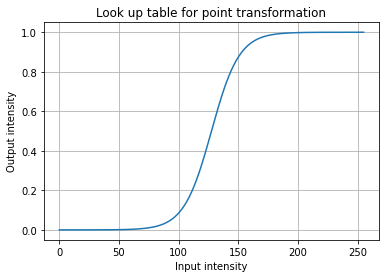

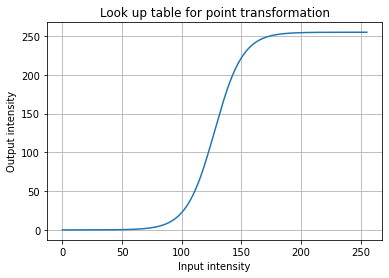

In [11]:
k=22
cent=0.5
lut = 1/(1+np.exp(-k*(np.linspace(0,1,256)-cent)))
plt.plot(lut)
plt.xlabel("Input intensity")
plt.ylabel("Output intensity")
plt.title("Look up table for point transformation")
plt.grid()
plt.show()

k=0.085
cent=255*0.5
lut = 255/(1+np.exp(-k*(np.arange(256)-cent)))
plt.plot(lut)
plt.xlabel("Input intensity")
plt.ylabel("Output intensity")
plt.title("Look up table for point transformation")
plt.grid()
plt.show()

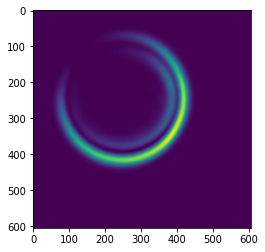

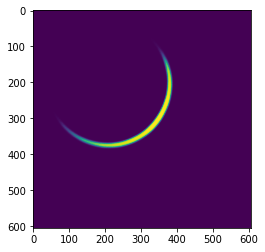

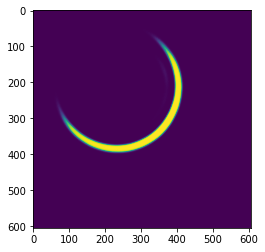

In [12]:
im = cv2.imread( "../EXPERIMENTAL/TEST_IMAGES/con_los_dos.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(im)
plt.show()

def sigmoid_no_lut_normalize_and_iX( images, in_are_dev_float, device, center=0.7, 
                       slope_squeezeness=50, dtype=torch.float64, X=302 ):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)    
    images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
    images = 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
    return compute_raws_to_centered_iXs_torch(images, X, device) # we need not noramlize them again if center if sigmoid chosen with sense
# Ojo! se usan los valores float del lut como valores de la imagen! (no los cuantizados!)
K=22
k=0.085

out_im = sigmoid_no_lut_normalize_and_iX(torch.from_numpy(im).unsqueeze(0), in_are_dev_float=False, device=device, slope_squeezeness=K)
plt.imshow(out_im[0].to('cpu').numpy())
plt.show()

out_im = sigmoid_lut_using_numpy_normalize_and_iX( torch.from_numpy(im).unsqueeze(0), in_are_dev=False, device=device, center=0.5, 
                       slope_squeezeness=k, max_val_lut_process=255, lut_process_dtype=torch.uint8,
                       output_dtype=torch.float64, X=302 )
plt.imshow(out_im[0].to('cpu').numpy())
plt.show()

# (A) ROTATION ALGORITHM

In [13]:
rotation_alg_kw_args = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}
rotation_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
rotation_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}

rotation_preprocess_fct = lambda images:  normalize_to_max_and_iX(images)

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_rotation_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, rotation_alg_kw_args, out_plot_path=None, rotation_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    image_loader = Image_Manager(mode=X, interpolation_flag=None)
    if rotation_algorithm is None:
        rotation_algorithm = Rotation_Algorithm(image_loader,
            rotation_alg_kw_args['theta_min_Rot'], rotation_alg_kw_args['theta_max_Rot'], 
            rotation_alg_kw_args['interpolation_flag'],
            rotation_alg_kw_args['initial_guess_delta_rad'], rotation_alg_kw_args['use_exact_gravicenter'], 
                                                initialize_it=False)
    image_names = []
    for mode in ['Ref', 'Pb']:
        for image_pair_name in image_pair_names:
            image_names.append(f"{mode}__{image_pair_name}")
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)
    image_loader.import_converted_images_as_array(images, image_names)
    # Execute the Rotation Algorithm:
    rotation_algorithm.interpolation_flag=rotation_alg_kw_args['interpolation_flag']
    rotation_algorithm.reInitialize(image_loader)
    # run it
    if search_algorithm=='quadratic':
        rotation_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        rotation_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    if out_plot_path is not None:
        rotation_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(rotation_algorithm.angles.values())
    ts = list(rotation_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i+len(image_pair_names)]) - angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i+len(image_pair_names)] + ts[i]
            
    return predicted_deltaPhiCRs, times

# (B) MIRROR FLIP ALGORITHM

In [14]:
mirror_alg_kw_args = {'theta_min_Mir':0, 'theta_max_Mir':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}
mirror_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
mirror_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}

mirror_preprocess_fct = lambda images: normalize_to_mean_and_iX(images)
# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_mirror_flip_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, mirror_alg_kw_args, out_plot_path=None, mirror_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    image_loader = Image_Manager(mode=X, interpolation_flag=None)
    if mirror_algorithm is None:
        mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
            mirror_alg_kw_args['theta_min_Mir'], mirror_alg_kw_args['theta_max_Mir'], 
            mirror_alg_kw_args['interpolation_flag'],
            mirror_alg_kw_args['initial_guess_delta_rad'], method="aff", left_vs_right=True, 
            use_exact_gravicenter=mirror_alg_kw_args['use_exact_gravicenter'], initialize_it=False)

    image_names = []
    for mode in ['Ref', 'Pb']:
        for image_pair_name in image_pair_names:
            image_names.append(f"{mode}__{image_pair_name}")
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)
    image_loader.import_converted_images_as_array(images, image_names)
    # Execute the Rotation Algorithm:
    mirror_algorithm.interpolation_flag=mirror_alg_kw_args['interpolation_flag']
    mirror_algorithm.reInitialize(image_loader)
    # run it
    if search_algorithm=='quadratic':
        mirror_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        mirror_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    
    if out_plot_path is not None:
        mirror_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(mirror_algorithm.angles.values())
    ts = list(mirror_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i+len(image_pair_names)]) - angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i+len(image_pair_names)] + ts[i]
    
    return predicted_deltaPhiCRs, times

# (C) Simulation Coordinate Descent using h5f library of D matrices

In [15]:
class Simulation_precomputed_R0_w0_Z_Dmatrices_optimize_phiCR():
    def __init__(self,  ID_file_path, D_matrix_file_path, device, coordinate_descent_cycles,
                 min_angle, max_angle, initial_guess_delta_rad, initial_guess_delta_R0,
                 preprocess_fct, similarity, R0_init_guess, w0_init_guess, Z_init_guess,
                 initial_R0_sweep_num, mirror_alg_kw_args, embedder=None):
        import json
        self.D_matrix_file_path = D_matrix_file_path
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(ID_file_path)))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.R0s_ar = np.array(self.R0s, dtype=np.float64) # Convert them to float arrays
        self.w0s_ar = np.array(self.w0s, dtype=np.float64)
        self.Zs_ar = np.array(self.Zs, dtype=np.float64)
        self.device = device
        if not hasattr(self, 'h5f_D_matrices'): # this was originally thought for multiprocess child threads to have the chance each to have an open copy of the hdf5 (which should be opened in the first iteration of the parallelized get, not here in the init, but well...)
            self.open_hdf5()
            self.phis = torch.from_numpy(self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(self.device) #[1,Nx,Ny]

        # search function params?
        self.cycles=coordinate_descent_cycles
        self.min_Z=min(self.Zs_ar)
        self.max_Z=max(self.Zs_ar)
        self.min_phi=min_angle
        self.max_phi=max_angle
        self.min_radi=min(self.R0s_ar)
        self.max_radi=max(self.R0s_ar)
        self.min_w0=min(self.w0s_ar)
        self.max_w0=max(self.w0s_ar)
        self.initial_guess_delta_rad=initial_guess_delta_rad
        self.initial_guess_delta_R0=initial_guess_delta_R0
        
        self.R0_precision=abs(self.R0s_ar[1]-self.R0s_ar[0])
        self.w0_precision=abs(self.w0s_ar[1]-self.w0s_ar[0])
        self.Z_precision=abs(self.Zs_ar[1]-self.Zs_ar[0])
        # pa phiCR no porke es unbounded!
        self.angle_optimizer=Ad_Hoc_Optimizer(min_angle, max_angle, initial_guess_delta_rad, self.evaluate_simulation_phi)
        self.radious_optimizer=Ad_Hoc_Optimizer(self.min_radi, self.max_radi, initial_guess_delta_R0, self.evaluate_simulation_R0)
        self.w0_optimizer=Ad_Hoc_Optimizer(self.min_w0, self.max_w0, initial_guess_delta_R0, self.evaluate_simulation_w0)
        self.Z_optimizer=Ad_Hoc_Optimizer(self.min_Z, self.max_Z, initial_guess_delta_R0, self.evaluate_simulation_Z)
        
        self.embedder = embedder
        self.choose_similarity_alg(similarity)

        self.times={}
        self.radious_points={}
        self.w0_points={}
        self.Z_points={}
        self.phi_points={}
        # use the results from the gradient algorithm to initialize the best triplet?
        self.R0_pix_best={}
        self.w0_best={}
        self.Z_best={}
        self.phi_CR_best={}
        self.last_cycle=coordinate_descent_cycles
        self.initial_R0_sweep_num=initial_R0_sweep_num
        self.best_radii={}
        self.best_w0s={}
        self.best_zs={}
        self.best_angles={}
        self.simulations_required={}
        
        self.similarity=similarity # the similarity metric to use as the objective function
        self.preprocess_fct = preprocess_fct
        self.last_R0=None
        self.last_w0=None
        self.last_Z=None
        
        self.R0_init_guess =R0_init_guess
        self.w0_init_guess = w0_init_guess
        self.Z_init_guess = Z_init_guess
        
        image_loader = Image_Manager(mode=X, interpolation_flag=None)
        self.algorithm_M = Mirror_Flip_Algorithm(image_loader,
            mirror_alg_kw_args['theta_min_Mir'], mirror_alg_kw_args['theta_max_Mir'], None,
            mirror_alg_kw_args['initial_guess_delta_rad'], method="aff", left_vs_right=True, 
            use_exact_gravicenter=mirror_alg_kw_args['use_exact_gravicenter'], initialize_it=False)
        
    def __del__(self):
        if hasattr(self, 'h5f_D_matrices'):
            self.h5f_D_matrices.close()
            
    def open_hdf5(self):
        self.h5f_D_matrices = h5py.File( self.D_matrix_file_path, 'r')
        #self.dataset = self.img_hdf5['dataset'] # if you want dataset.

    def angle_to_pi_pi(self, angle): # convert any angle to range ()-pi,pi]
        angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
        return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle
        
    def closest_idx_in_ar(self, value, list_array): # hay que meterle una periodicidad como con los angulos porke los algs de optimizacion están pensados para que así sea
        return (np.abs(list_array-value)).argmin()
        
    def closest_in_ar_periodic(self, value, list_array, delta):
        idxs = (np.round((value-min(list_array))/delta)%len(list_array)).astype(int)
        return list_array[ idxs ]
    
    def plot(self, guess, pb):
        im = torch.cat((guess, pb))
        plt.imshow(im.to('cpu').numpy())
        plt.show()
        
    def get_simulated_image(self, R0, w0, Z, phiCR):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{self.closest_in_ar_periodic(R0, self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(self.device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        phiCRs = torch.tensor([self.angle_to_pi_pi(phiCR)]).to(self.device) #[num_phiCR, 1, 1]
        images = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        return self.preprocess_fct(images, in_are_dev_float=True, device=self.device)

    def choose_similarity_alg(self, similarity):
        if similarity == 'mse': # mean square error
            self.similarity_func = lambda im1, im2: torch.sum(torch.square(im1-im2)).item()
        elif similarity == 'mae': # mean absolute error
            self.similarity_func = lambda im1, im2: torch.sum(torch.abs(im1-im2)).item()
        elif similarity == 'mae_pwp':
            self.similarity_func = lambda im1, im2: -torch.sum(im1*im2/torch.max(im1*im2).item()).item()
        elif similarity == 'use_embedding':
            self.similarity_func = lambda im1, im2: torch.sum(torch.square(self.embedder(im1)-self.embedder(im2))).item()
        
        # NOT TORCHIZISED!
        elif similarity == 'ssim':
            self.similarity_func = lambda im1, im2: -ism.ssim(im1, im2)
        elif similarity == 'fsim':
            self.similarity_func = lambda im1, im2: -ism.fsim(np.expand_dims(im1,2), np.expand_dims(im2,2))
        elif similarity == 'issm':
            self.similarity_func = lambda im1, im2: ism.issm(im1, im2)
        elif similarity == 'sre':
            self.similarity_func = lambda im1, im2: -ism.sre(np.expand_dims(im1,2), np.expand_dims(im2,2))
        elif similarity == 'sam':
            self.similarity_func = lambda im1, im2: -ism.sam(np.expand_dims(im1,2), np.expand_dims(im2,2))
        elif similarity == 'uiq':
            self.similarity_func = lambda im1, im2: -ism.uiq(np.expand_dims(im1,2), np.expand_dims(im2,2))
        # ADD DL trained Similarity Metric!

        
    def reInitialize_and_input_images(self, images, image_names,
                     preprocess_fct=None, coordinate_descent_cycles=None, similarity=None,
                    R0_init_guess=None, w0_init_guess=None, Z_init_guess=None, embedder=None): 
        if type(images)!=torch.Tensor:
            images = torch.from_numpy(images).to(self.device)            
        self.images = self.preprocess_fct(images, in_are_dev_float=False, device=self.device)
        self.image_names = image_names
        self.times={}
        self.radious_points={}
        self.w0_points={}
        self.Z_points={}
        self.phi_points={}
        self.R0_pix_best={}
        self.w0_best={}
        self.Z_best={}
        self.phi_CR_best={}
        self.last_cycle=coordinate_descent_cycles

        self.best_radii={}
        self.best_w0s={}
        self.best_zs={}
        self.best_angles={}
        self.simulations_required={}
        
        self.last_R0=None
        self.last_w0=None
        self.last_Z=None

        image_loader_for_M = Image_Manager(mode=X, interpolation_flag=None)
        image_loader_for_M.import_converted_images_as_array( self.images.to('cpu').numpy(), self.image_names )
        self.algorithm_M.reInitialize(image_loader_for_M)
        
        if similarity is not None:
            self.embedder=embedder
            self.similarity=similarity
            self.choose_similarity_alg(similarity)
        if preprocess_fct is not None:
            self.preprocess_fct = preprocess_fct
        if coordinate_descent_cycles is not None:
            self.cycles=coordinate_descent_cycles
        if R0_init_guess is not None:
            self.R0_init_guess = R0_init_guess
        if w0_init_guess is not None:
            self.w0_init_guess = w0_init_guess
        if Z_init_guess is not None:
            self.Z_init_guess = Z_init_guess

    def evaluate_simulation_phi(self, exp_image, phiCR, R0_best, Z_best, w0_best): # exp im expected to be [1,h,w]
        return self.similarity_func(exp_image, self.get_simulated_image(R0_best, w0_best, Z_best, phiCR))

    def evaluate_simulation_R0(self, exp_image, R0, angle_best, Z_best, w0_best):
        return self.similarity_func(exp_image, self.get_simulated_image(R0, w0_best, Z_best, angle_best))


    def evaluate_simulation_Z(self, exp_image, Z, angle_best, R0_best, w0_best):
        return self.similarity_func(exp_image, self.get_simulated_image(R0_best, w0_best, Z, angle_best))


    def evaluate_simulation_w0(self, exp_image, w0, angle_best, R0_best, Z_best):
        return self.similarity_func(exp_image, self.get_simulated_image(R0_best, w0, Z_best, angle_best))

    def initial_sweep_R0(self, exp_image, phiCR, Z, w0):
        R0s_to_try = self.R0s[::len(self.R0s)//self.initial_R0_sweep_num]
        costs=[self.evaluate_simulation_R0(exp_image, float(R0), phiCR, Z, w0) for R0 in R0s_to_try]
        return float(R0s_to_try[np.argmin(costs)])
        

    def fibonacci_ratio_search(self, precision_R0, maximum_points_R0, precision_phi,
        maximum_points_phi, precision_Z, maximum_points_Z,  precision_w0, maximum_points_w0, cost_tol,
        precision_M, maximum_points_M, cost_tol_M):
        # We first find an estimation for phiCR using the mirror flip algorithm
        self.algorithm_M.fibonacci_ratio_search(precision_M, maximum_points_M, cost_tol_M)
        
        # We now execute a sequence of linear optimizations for each coordinate for every cycle and image
        for im, name in enumerate(self.image_names):
            self.times[name]={}
            self.radious_points[name]={}
            self.Z_points[name]={}
            self.w0_points[name]={}
            self.phi_points[name]={}
            # use the results from the gradient algorithm to initialize the best triplet
            #self.R0_pix_best[name]=[1.65*abs(self.algorithm_G.optimals[f'Fibonacci_Search_{name}'])]
            self.R0_pix_best[name]=[self.R0_init_guess]
            self.Z_best[name]=[self.Z_init_guess]
            self.w0_best[name]=[self.w0_init_guess]
            # Initialize the phiCR with the result from the mirror flip agorithm
            self.phi_CR_best[name]=[self.algorithm_M.angles[f'Fibonacci_Search_{name}']]
            # Make an initial sweep of R0 to get a good enough initial guess
            self.R0_pix_best[name]=[self.initial_sweep_R0( self.images[im], self.phi_CR_best[name][-1], self.Z_best[name][-1], self.w0_best[name][-1])]
            simulations=0
            for cycle in range(self.cycles):
                # Optimize Radious
                (time_rad, self.radious_points[name][cycle], R0_pix_best, radi_optimum,
                 _)=self.radious_optimizer.fibonacci_ratio_search(
                    precision_R0, maximum_points_R0, cost_tol,
                    self.images[im].unsqueeze(0),
                    (self.phi_CR_best[name][-1], self.Z_best[name][-1], self.w0_best[name][-1]), self.R0_pix_best[name][-1]
                )
                self.radious_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.radious_points[name][cycle][:,0], self.R0s_ar, self.R0_precision)
                R0_pix_best = self.closest_in_ar_periodic(R0_pix_best, self.R0s_ar, self.R0_precision)
                
                # Optimize w0 - the width of the croissant
                (time_w0, self.w0_points[name][cycle], w0_best, w0_optimum,
                 _)=self.w0_optimizer.fibonacci_ratio_search(
                    precision_w0, maximum_points_w0, cost_tol,
                    self.images[im].unsqueeze(0),
                    (self.phi_CR_best[name][-1], R0_pix_best, self.Z_best[name][-1]), self.w0_best[name][-1]
                )
                self.w0_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.w0_points[name][cycle][:,0], self.w0s_ar, self.w0_precision)
                w0_best = self.closest_in_ar_periodic(w0_best, self.w0s_ar, self.w0_precision)
                 
                # Optimize Z
                if maximum_points_Z!=0:
                    self.Z_optimizer.a=-2*np.sqrt(1/3)*w0_best
                    self.Z_optimizer.b=-self.Z_optimizer.a
                    (time_Z, self.Z_points[name][cycle], Z_best, Z_optimum,
                        _)=self.Z_optimizer.fibonacci_ratio_search(
                            precision_Z, maximum_points_Z, cost_tol,
                            self.images[im].unsqueeze(0),
                            (self.phi_CR_best[name][-1], R0_pix_best, w0_best), self.Z_best[name][-1]
                        )
                    self.Z_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.Z_points[name][cycle][:,0], self.Zs_ar, self.Z_precision)
                    Z_best = self.closest_in_ar_periodic(Z_best, self.Zs_ar, self.Z_precision)
                
                else: # dont optimize z
                    time_Z=0
                    Z_best=0
                    Z_optimum=0
                    self.Z_points[name][cycle]=np.array([[0,0,0]])
                
                # Optimize Angle
                (time_ang, self.phi_points[name][cycle], phi_CR_best, phi_optimum, _)=self.angle_optimizer.fibonacci_ratio_search(
                    precision_phi, maximum_points_phi, cost_tol,
                    self.images[im].unsqueeze(0),
                    (R0_pix_best, Z_best, w0_best), self.phi_CR_best[name][-1]
                )
                
                self.times[name][cycle]=time_rad+time_ang+time_Z+time_w0
                self.R0_pix_best[name].append(R0_pix_best)
                self.phi_CR_best[name].append(phi_CR_best)
                self.w0_best[name].append(w0_best)
                self.Z_best[name].append(Z_best)

                simulations+=len(self.phi_points[name][cycle])+len(self.radious_points[name][cycle])+len(self.Z_points[name][cycle])+len(self.w0_points[name][cycle])

                # check if convergence criterion is met
                if((abs(Z_optimum-phi_optimum)<cost_tol and
                        abs(phi_optimum-radi_optimum)<cost_tol and
                            abs(radi_optimum-w0_optimum)<cost_tol)
                        or (abs(self.R0_pix_best[name][-2]-R0_pix_best)<precision_R0 and
                        abs(self.phi_CR_best[name][-2]-phi_CR_best)<precision_phi and
                        abs(self.Z_best[name][-2]-Z_best)<precision_Z) and
                        abs(self.w0_best[name][-2]-w0_best<precision_w0)):
                    self.last_cycle=cycle+1
                    break
            self.best_radii[name]=R0_pix_best
            self.best_w0s[name]=w0_best
            self.best_zs[name]=Z_best
            self.best_angles[name]=self.angle_to_pi_pi(phi_CR_best)
            self.simulations_required[name]=simulations
            print(f"Image {im} optimized!")


    def quadratic_fit_search(self, precision_R0, maximum_points_R0, precision_phi,
        maximum_points_phi, precision_Z, maximum_points_Z, precision_w0, maximum_points_w0, cost_tol,
        precision_M, maximum_points_M, cost_tol_M):
        # We first find an estimation for R0 and phiCR using the gradient algorithm
        self.algorithm_M.quadratic_fit_search(precision_M, maximum_points_M, cost_tol_M)

        # We now execute a sequence of linear optimizations for each coordinate for every cycle
        for im, name in enumerate(self.image_names):
            self.times[name]={}
            self.radious_points[name]={}
            self.Z_points[name]={}
            self.w0_points[name]={}
            self.phi_points[name]={}
            # use the results from the gradient algorithm to initialize the best triplet
            #self.R0_pix_best[name]=[1.65*abs(self.algorithm_G.optimals[f'Fibonacci_Search_{name}'])]
            self.R0_pix_best[name]=[self.R0_init_guess]
            self.Z_best[name]=[self.Z_init_guess]
            self.w0_best[name]=[self.w0_init_guess]
            # Initialize the phiCR with the result from the mirror flip agorithm
            self.phi_CR_best[name]=[self.algorithm_M.angles[f'Quadratic_Search_{name}']]
            # Make an initial sweep of R0 to get a good enough initial guess
            self.R0_pix_best[name]=[self.initial_sweep_R0( self.images[im], self.phi_CR_best[name][-1], self.Z_best[name][-1], self.w0_best[name][-1])]
            simulations=0
            for cycle in range(self.cycles):
               
                # Optimize Radious
                (time_rad, self.radious_points[name][cycle], R0_pix_best, radi_optimum,
                 _)=self.radious_optimizer.quadratic_fit_search(
                    precision_R0, maximum_points_R0, cost_tol,
                    self.images[im].unsqueeze(0),
                    (self.phi_CR_best[name][-1], self.Z_best[name][-1], self.w0_best[name][-1]), self.R0_pix_best[name][-1]
                )
                self.radious_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.radious_points[name][cycle][:,0], self.R0s_ar, self.R0_precision)
                R0_pix_best = self.closest_in_ar_periodic(R0_pix_best, self.R0s_ar, self.R0_precision)
                
                # Optimize w0 magnitude - the width of the croissant
                (time_w0, self.w0_points[name][cycle], w0_best, w0_optimum,
                 _)=self.w0_optimizer.quadratic_fit_search(
                    precision_w0, maximum_points_w0, cost_tol,
                    self.images[im].unsqueeze(0),
                    (self.phi_CR_best[name][-1], R0_pix_best, self.Z_best[name][-1]), self.w0_best[name][-1]
                )
                self.w0_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.w0_points[name][cycle][:,0], self.w0s_ar, self.w0_precision)
                w0_best = self.closest_in_ar_periodic(w0_best, self.w0s_ar, self.w0_precision)

                # Optimize Z
                if maximum_points_Z!=0:
                    self.Z_optimizer.a=-2*np.sqrt(1/3)*R0_pix_best*self.simulator.dx
                    self.Z_optimizer.b=-self.Z_optimizer.a
                    (time_Z, self.Z_points[name][cycle], Z_best, Z_optimum,
                        _)=self.Z_optimizer.quadratic_fit_search(
                            precision_Z, maximum_points_Z, cost_tol,
                            self.images[im].unsqueeze(0),
                            (self.phi_CR_best[name][-1], R0_pix_best, w0_best), self.Z_best[name][-1]
                        )
                    self.Z_points[name][cycle][:,0]=self.closest_in_ar_periodic(self.Z_points[name][cycle][:,0], self.Zs_ar, self.Z_precision)
                    Z_best = self.closest_in_ar_periodic(Z_best, self.Zs_ar, self.Z_precision)
                
                else: # dont optimize z
                    time_Z=0
                    Z_best=0
                    Z_optimum=0
                    self.Z_points[name][cycle]=np.array([[0,0,0]])
                
                # Optimize Angle
                (time_ang, self.phi_points[name][cycle], phi_CR_best, phi_optimum, _)=self.angle_optimizer.quadratic_fit_search(
                    precision_phi, maximum_points_phi, cost_tol,
                    self.images[im].unsqueeze(0),
                    (R0_pix_best, Z_best, w0_best), self.phi_CR_best[name][-1]
                )

                self.times[name][cycle]=time_rad+time_ang+time_Z+time_w0
                self.R0_pix_best[name].append(R0_pix_best)
                self.w0_best[name].append(w0_best)
                self.phi_CR_best[name].append(phi_CR_best)
                self.Z_best[name].append(Z_best)

                simulations+=len(self.phi_points[name][cycle])+len(self.radious_points[name][cycle])+len(self.Z_points[name][cycle])+len(self.w0_points[name][cycle])

                # check if convergence criterion is met
                if((abs(Z_optimum-phi_optimum)<cost_tol and
                        abs(phi_optimum-radi_optimum)<cost_tol and
                            abs(radi_optimum-w0_optimum)<cost_tol)
                        or (abs(self.R0_pix_best[name][-2]-R0_pix_best)<precision_R0 and
                        abs(self.phi_CR_best[name][-2]-phi_CR_best)<precision_phi and
                        abs(self.Z_best[name][-2]-Z_best)<precision_Z) and
                        abs(self.w0_best[name][-2]-w0_best<precision_w0)):
                    self.last_cycle=cycle+1
                    break
            self.best_radii[name]=R0_pix_best
            self.best_w0s[name]=w0_best
            self.best_zs[name]=Z_best
            self.best_angles[name]=self.angle_to_pi_pi(phi_CR_best)
            self.simulations_required[name]=simulations
            print(f"Image {im} optimized!")

    def plot_best_found_ones(self, out_path):
        os.makedirs(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/", exist_ok=True)
        fig = plt.figure(figsize=(2*4.5, len(self.image_names)*4.5))
        axes=fig.subplots(len(self.image_names),2)
        if len(axes.shape)==1:
            axes=np.expand_dims(axes, 0)
        for k, (name, optimal_angle) in enumerate(self.best_angles.items()):
            axes[k, 0].imshow(self.images[k].to('cpu').numpy())        
            axes[k, 1].imshow(self.get_simulated_image( R0=self.best_radii[name],
                w0=self.best_w0s[name], Z=self.best_zs[name], phiCR=self.best_angles[name]).to('cpu').numpy()[0])
            axes[k,0].set_title(f"Experimental Image {name}\nOptimal phiCR {optimal_angle}")
            axes[k,1].set_title(f"Fitted Image: \nR0={self.best_radii[name]}pix w0={self.best_w0s[name]}pix\n Z={self.best_zs[name]}pix phiCR={self.best_angles[name]}rad")
        fig.suptitle("Results of the Simulation Coordinate Descent Algorithm")
        plt.savefig(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/Net_Results.png")
        
    def save_result_plots(self, out_path, meth_name):
        os.makedirs(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/", exist_ok=True)
        self.algorithm_M.save_result_plots_fibonacci_or_quadratic(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/")
        fig = plt.figure(figsize=(4*10, 10*self.last_cycle))

        for k, name in enumerate(self.phi_points.keys()):
            axes = fig.subplots(self.last_cycle, 4)
            if self.last_cycle==1:
                axes=np.expand_dims(axes,0)
            for cycle in range(self.last_cycle):
                axes[cycle, 0].plot(self.w0_points[name][cycle][:,0], self.w0_points[name][cycle][:,1], 'o', label=f'w0 pixels descent fixing phiCR={self.phi_CR_best[name][cycle]}; R0 pix={self.R0_pix_best[name][cycle]}; Z={self.Z_best[name][cycle]}')
                axes[cycle, 1].plot(self.radious_points[name][cycle][:,0], self.radious_points[name][cycle][:,1], 'o', label=f'R0 pixels descent fixing w0 pix ={self.w0_best[name][cycle+1]}; phiCR={self.phi_CR_best[name][cycle]}; Z={self.Z_best[name][cycle]}')
                axes[cycle, 2].plot(self.phi_points[name][cycle][:,0], self.phi_points[name][cycle][:,1], 'o', label=f'phiCR descent fixing w0 pix ={self.w0_best[name][cycle+1]}; R0 pix={self.R0_pix_best[name][cycle+1]}; Z={self.Z_best[name][cycle]}')
                axes[cycle, 3].plot(self.Z_points[name][cycle][:,0], self.Z_points[name][cycle][:,1], 'o', label=f'Z descent fixing w0 pix ={self.w0_best[name][cycle+1]}; R0 pix={self.R0_pix_best[name][cycle+1]}; phiCR={self.phi_CR_best[name][cycle+1]}')

                axes[cycle, 0].set_xlabel("w0 (pixels)")
                axes[cycle, 1].set_xlabel("R0 (pixels)")
                axes[cycle, 2].set_xlabel("phi_CR (rad)")
                axes[cycle, 3].set_xlabel("Z (w0-s)")
                axes[cycle, 0].set_title(f"Best of cycle={self.w0_best[name][cycle+1]}\n Computed points={len(self.w0_points[name][cycle])}")
                axes[cycle, 1].set_title(f"Best of cycle={self.R0_pix_best[name][cycle+1]}\n Computed points={len(self.radious_points[name][cycle])}")
                axes[cycle, 2].set_title(f"Best of cycle={self.phi_CR_best[name][cycle+1]}\n Computed points={len(self.phi_points[name][cycle])}")
                axes[cycle, 3].set_title(f"Best of cycle={self.Z_best[name][cycle+1]}\n Computed points={len(self.Z_points[name][cycle])}")

                for i in range(4):
                    axes[cycle, i].set_ylabel("sum(abs(simulated_image(phiCR, R0_pix, w0_pix, Z)-exp_image))")
                    axes[cycle, i].grid(True)
                    axes[cycle, i].legend()

                fig.suptitle(f"{meth_name}  {name}\nBest triplet: phiCR={self.best_angles[name]}rad; R0_pix={self.best_radii[name]}pix; w0={self.best_w0s[name]}(pix); Z={self.best_zs[name]}w0")
            plt.savefig(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/{meth_name}__{name}.png")
            fig.clf()
            I=self.get_simulated_image( R0=self.best_radii[name],
                w0=self.best_w0s[name], Z=self.best_zs[name], phiCR=self.best_angles[name]).to('cpu').numpy()
            I = (255*I/I.max())[0] #[h,w]
            cv2.imwrite(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/iX_{X}_Left_Exp_[{name}]_Right_Simul_PolAngle_{self.best_angles[name]/2:.15f}_CRAngle_{self.best_angles[name]:.15f}_Z_{self.best_zs[name]}_R0_pix_{self.best_radii[name]}_w0_pix_{self.best_w0s[name]}.png",
                np.concatenate((I, (255*(self.images[k].type(torch.float64)/self.images[k].max())).to('cpu').numpy()),axis=1))

In [16]:
ID_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Encoder_Alone/Dataset_R0_70_w0_70_Z_4.h5"
#ID_file_path = "/media/melanie/D459-5113/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
#D_matrix_file_path = "/media/melanie/D459-5113/Dataset_R0_70_w0_70_Z_4.h5"

mirror_alg_sim_kw_args = {'theta_min_Mir':0, 'theta_max_Mir':np.pi, 'initial_guess_delta_rad':0.4, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC}

simulation_alg_kw_args = {'ID_file_path':ID_file_path, 'D_matrix_file_path':D_matrix_file_path, 'device':device, 
                        'coordinate_descent_cycles':3, 'min_angle':-np.pi,
                       'max_angle':np.pi,'initial_guess_delta_rad':0.1, 'initial_guess_delta_R0':1,
                        'similarity':'mae','R0_init_guess':158.0, 'w0_init_guess':25.0, 'Z_init_guess':0.0,
                          'initial_R0_sweep_num':10
                       }
simulation_fibo_kw_args = {'precision_R0':1e-10, 'maximum_points_R0':20, 'precision_phi':1e-10,
                        'maximum_points_phi':100, 'precision_Z':1e-2, 'maximum_points_Z':0, 
                         'precision_w0':1e-10, 'maximum_points_w0':20, 'cost_tol':1e-14, 'precision_M':1e-4,
                        'maximum_points_M':100, 'cost_tol_M':1e-14}

simulation_quad_kw_args = {'precision_R0':1e-10, 'maximum_points_R0':20, 'precision_phi':1e-10,
                        'maximum_points_phi':100, 'precision_Z':1e-2, 'maximum_points_Z':0, 
                         'precision_w0':1e-10, 'maximum_points_w0':20, 'cost_tol':1e-14, 'precision_M':1e-4,
                        'maximum_points_M':100, 'cost_tol_M':1e-14}

simulation_preprocess_fct = lambda images, in_are_dev_float, device : normalize_to_mean_saturate_to_max_and_iX_torch(images, \
                                            in_are_dev_float,  device=device,  dtype=torch.float64, X=302,
                                            saturation_threshold=torch.tensor([0.1], device=device))

simulation_preprocess_fct = lambda images, in_are_dev_float, device : normalize_to_max_and_iX_torch(images, 
                                                                                    in_are_dev_float, device=device)


# also, at least in this case, expected to be torch arrays!
def run_simulation_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, simulation_alg_kw_args,mirror_alg_kw_args,
                             out_plot_path=None, simulation_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    if simulation_algorithm is None:
        simulation_algorithm = Simulation_precomputed_R0_w0_Z_Dmatrices_optimize_phiCR(
            ID_file_path=simulation_alg_kw_args['ID_file_path'], 
            D_matrix_file_path=simulation_alg_kw_args['D_matrix_file_path'], device=simulation_alg_kw_args['device'],
            coordinate_descent_cycles=simulation_alg_kw_args['coordinate_descent_cycles'],
            min_angle=simulation_alg_kw_args['min_angle'], max_angle=simulation_alg_kw_args['max_angle'], 
            initial_guess_delta_rad=simulation_alg_kw_args['initial_guess_delta_rad'], 
            initial_guess_delta_R0=simulation_alg_kw_args['initial_guess_delta_R0'],
            preprocess_fct=preprocess_fct, similarity=simulation_alg_kw_args['similarity'],
            R0_init_guess=simulation_alg_kw_args['R0_init_guess'], w0_init_guess=simulation_alg_kw_args['w0_init_guess'], 
            Z_init_guess=simulation_alg_kw_args['Z_init_guess'],initial_R0_sweep_num=simulation_alg_kw_args['initial_R0_sweep_num'],
            mirror_alg_kw_args=mirror_alg_kw_args
            )
    image_names = []
    for mode in ['Ref', 'Pb']:
        for image_pair_name in image_pair_names:
            image_names.append(f"{mode}__{image_pair_name}")
    # charge the image loader:
    if type(references)!=torch.Tensor or type(problems)!=torch.Tensor:
        images = np.concatenate((references, problems), axis=0)
        images = torch.from_numpy(images).to(device)
    else:
        images = torch.cat((references, problems), dim=0)

    # Execute the Simulation Algorithm:
    simulation_algorithm.reInitialize_and_input_images( images, image_names,
                     preprocess_fct=preprocess_fct, coordinate_descent_cycles=simulation_alg_kw_args['coordinate_descent_cycles'],
                    similarity=simulation_alg_kw_args['similarity'],
                R0_init_guess=simulation_alg_kw_args['R0_init_guess'],
                w0_init_guess=simulation_alg_kw_args['w0_init_guess'],
                Z_init_guess=simulation_alg_kw_args['Z_init_guess'])
    # run it
    if search_algorithm=='quadratic':
        simulation_algorithm.quadratic_fit_search(precision_R0=search_alg_kw_args['precision_R0'],
            maximum_points_R0=search_alg_kw_args['maximum_points_R0'], precision_phi=search_alg_kw_args['precision_phi'],
            maximum_points_phi=search_alg_kw_args['maximum_points_phi'], precision_Z=search_alg_kw_args['precision_Z'], 
            maximum_points_Z=search_alg_kw_args['maximum_points_Z'],  precision_w0=search_alg_kw_args['precision_w0'],
            maximum_points_w0=search_alg_kw_args['maximum_points_w0'], cost_tol=search_alg_kw_args['cost_tol'],
            precision_M=search_alg_kw_args['precision_M'], maximum_points_M=search_alg_kw_args['maximum_points_M'],
                                                  cost_tol_M=search_alg_kw_args['cost_tol_M'])
        if out_plot_path is not None:
            simulation_algorithm.save_result_plots(out_plot_path, 'Quadratic')
    else: # 'fibo'
        simulation_algorithm.fibonacci_ratio_search(precision_R0=search_alg_kw_args['precision_R0'],
            maximum_points_R0=search_alg_kw_args['maximum_points_R0'], precision_phi=search_alg_kw_args['precision_phi'],
            maximum_points_phi=search_alg_kw_args['maximum_points_phi'], precision_Z=search_alg_kw_args['precision_Z'], 
            maximum_points_Z=search_alg_kw_args['maximum_points_Z'],  precision_w0=search_alg_kw_args['precision_w0'],
            maximum_points_w0=search_alg_kw_args['maximum_points_w0'], cost_tol=search_alg_kw_args['cost_tol'],
            precision_M=search_alg_kw_args['precision_M'], maximum_points_M=search_alg_kw_args['maximum_points_M'],
                                                  cost_tol_M=search_alg_kw_args['cost_tol_M'])    
        if out_plot_path is not None:
            simulation_algorithm.save_result_plots(out_plot_path, 'Fibonacci')

    if out_plot_path is not None:
        simulation_algorithm.plot_best_found_ones(out_plot_path)
    
    angles = list(simulation_algorithm.best_angles.values())
    ts = list(simulation_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i+len(image_pair_names)]) - angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = sum(ts[i+len(image_pair_names)].values()) + sum(ts[i].values())
    
    return predicted_deltaPhiCRs, times

# (D) Naive Affine Rotation

In [17]:
class Naive_Affine_Rotation():
    def __init__(self, X, min_angle, max_angle, interpolation_flag, initial_guess_delta, use_exact_gravicenter):
        #Polarization_Obtention_Algorithm.__init__(self,image_loader, use_exact_gravicenter)
        #self.original_images = image_loader
        self.mode = X
        self.use_exact_gravicenter=use_exact_gravicenter
        self.angles={}
        self.precisions={}
        
        self.interpolation_flag = interpolation_flag
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.initial_guess_delta = initial_guess_delta
        self.computed_points={}
        self.optimums={}
        self.optimals={}
        self.times={}
        self.cols=np.broadcast_to( np.arange(self.mode*2+1), (self.mode*2+1,self.mode*2+1)) #[h,w]
        self.optimizer = Ad_Hoc_Optimizer(min_angle, max_angle, initial_guess_delta, self.evaluate_image_rotation)
        
    def reInitialize_and_input_images(self, ref_images, pb_images, image_pair_names):     
        # Reference image in position k is the reference for the problem image in position k
        # both arrays will be [N_im, H,W]            
        self.reference_images = ref_images
        self.problem_images = pb_images
        self.image_pair_names = image_pair_names
        
        self.angles={}
        self.precisions={}
        self.computed_points={}
        self.optimums={}
        self.optimals={}
        self.times={}
        self.cols=np.broadcast_to( np.arange(self.mode*2+1), (self.mode*2+1,self.mode*2+1)) #[h,w]
        
        if self.use_exact_gravicenter: # GRAVICENTRUM KALKULEU!
            self.grav_ref = self.compute_intensity_gravity_centers(ref_images) #[N_images, 2(h,w)]
            self.grav_pb = self.compute_intensity_gravity_centers(pb_images)
        else:
            # gravicenter the same for all
            self.grav=np.array(2*[self.mode])+0.5

    def angle_to_pi_pi(self, angle): # convert any angle to range ()-pi,pi]
        angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
        return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle

    
    def compute_intensity_gravity_centers(self, images):
        """
            Expects input images to be an array of dimensions [N_images, h, w].
            It will return an array of gravity centers [N_images, 2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to numpy indices, so they being at 0
        """
        # image wise total intensity and marginalized inensities for weighted sum
        # (preserves axis 0, where images are stacked)
        intensity_in_w = np.sum(images, axis=1) # weights for x [N_imgs, raw_width]
        intensity_in_h = np.sum(images, axis=2) # weights for y [N_imgs, raw_height]
        total_intensity = intensity_in_h.sum(axis=1)

        # Compute mass center for intensity (in each image axis)
        # [N_images, 2] (h_center,w_center)
        return np.nan_to_num( np.stack(
            (np.dot(intensity_in_h, np.arange(images.shape[-2]))/total_intensity,
             np.dot(intensity_in_w, np.arange(images.shape[-1]))/total_intensity)
            ).transpose() )

    def rotate_image_by(self, image_array, angle, center):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=self.interpolation_flag).astype(image_array.dtype)
     
    def translate_image_and_rotate_by(self, image_array, angle, rotation_center, translation):
        """
        first translation then rotation about that special center is done
        rotation_center is expected to be a point [h,w]
        the translation is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64(
                [[a, b, translation[1]*a+translation[0]*b+rotation_center[1]*(1-a)-rotation_center[0]*b],
                 [-b, a, -translation[1]*b+translation[0]*a+rotation_center[1]*b+rotation_center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=self.interpolation_flag).astype(image_array.dtype)


    def evaluate_image_rotation(self, reference_image, angle, image_to_rotate, center_ref, center_pb):
        return np.sum(np.abs(self.translate_image_and_rotate_by(
                                image_to_rotate, angle, center_ref, center_ref-center_pb)
                             -reference_image))


    def given_axis_angle_greater_minus_lower(self, angle, image, center):
        # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
        # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
        mask=np.less(self.cols.swapaxes(0,1), np.tan(-angle)*(self.cols-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
            # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
        return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

    def get_polarization_angle(self, angle, image, center):
        """
        All the mirror methods have the problem that we only get the
        correct angle up to an angle pi. In order to know which is the
        angle to the maximum of the ring (and not the minimum) a final
        subtle check is required.
        """
        #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
        if angle==0 or abs(angle)==np.pi:
            angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
        diff=self.given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center)

        if diff>0: # then Upper>Lower -> then good one is the one in (0,pi)
            return angle+np.pi if angle<0 else angle
        else:
            return angle-np.pi if angle>0 else angle

    def brute_force_search(self, angle_steps, zoom_ratios):
        """
        What does this exactly do

        Arguments
        --------
        - angle_steps (list): A list of the different angle steps to take in each of the sweeps.
            Expected N, where N is the number of sweeps that will be performed. The first one is
            expected to be the coarsest grain and they should be ordered from big to smallest.
            The last step in the list will define the precision of the found minimum. The angle
            steps are expected to be in (0, 2pi)

        - zoom_ratios (list): A list of the interval reductions that will be held after each sweep
            around the current best candidate for the minimum. There should be N-1 elements and
            they should be numbers in (0,1].

        """
        zoom_ratios.append(1) #to avoid out of index in the last iteration
        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Brute_Force_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            self.optimals[name],
            self.optimums[name],
            self.precisions[name]) = self.optimizer.brute_force_search(
                    angle_steps, zoom_ratios,
                    self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav
                            ))
            self.optimals[name][f"Stage_{len(angle_steps)-1}"] =self.angle_to_pi_pi(self.optimals[name][f"Stage_{len(angle_steps)-1}"])
            self.angles[name]=-self.get_polarization_angle(self.optimals[name][f"Stage_{len(angle_steps)-1}"], self.images_float[im],
                self.grav[im] if self.use_exact_gravicenter else self.grav
            )


    def fibonacci_ratio_search(self, precision, maximum_points, cost_tol):
        """
        Arguments
        --------
        - precision (float): Half the length of the interval achieved in the last step. It will be
            the absolute error to which we compute the minimum of the funtion. Note however that
            the precision will have a minimum depending on the image quality and the minimum
            rotation arithmetics. Noise or discretization can induce plateaus in the minimum.
            Therefore, if at some point the three points have the same cost function the algorithm
            will stop: the cost function has arrived to the plateau. In that case the precision will
            be outputed accordingly.

        - maximum_points (int): Maximum number of points to use in the minimum search. It is also
            the number of times to make an interval reduction.

        - cost_tol (float): Maximum relative difference between the cost function active points
            tolerated before convergence assumption.
        """

        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Fibonacci_Search_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            optimal,
            self.optimums[name],
            self.precisions[name])=         self.optimizer.fibonacci_ratio_search(
                    precision, maximum_points, cost_tol,
                    self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav
                                                                   ))
            self.optimals[name]=self.angle_to_pi_pi(optimal)
            #self.angles[name]=self.get_polarization_angle(self.optimals[name]/2, self.images_float[im],
            #    self.grav[im] if self.use_exact_gravicenter else self.grav)
            self.angles[name]=-self.optimals[name]

    def quadratic_fit_search(self, precision, max_iterations, cost_tol):
        """
        Quadratic

        Arguments
        --------
        - precision (float): Half the length of the interval achieved in the last step. It will be
            the absolute error to which we compute the minimum of the funtion. Note however that
            the precision will have a minimum depending on the image quality and the minimum
            rotation arithmetics. Noise or discretization can induce plateaus in the minimum.
            Therefore, if at some point the three points have the same cost function the algorithm
            will stop: the cost function has arrived to the plateau. In that case the precision will
            be outputed accordingly.

        - max_iterations (int): Number of maximum iterations of quadratic function fit and
            minimization to tolerate.

        - cost_tol (float): Maximum relative difference between the cost function active points
            tolerated before convergence assumption.

        """
        for im, image_pair_name in enumerate(self.image_pair_names):
            name=f"Quadratic_Search_{image_pair_name}"
            (self.times[name],
            self.computed_points[name],
            optimal,
            self.optimums[name],
            self.precisions[name])=self.optimizer.quadratic_fit_search(
                precision, max_iterations, cost_tol,
                self.reference_images[im], (self.problem_images[im],
                    self.grav_ref[im] if self.use_exact_gravicenter else self.grav,
                    self.grav_pb[im] if self.use_exact_gravicenter else self.grav))
            self.optimals[name]=self.angle_to_pi_pi(optimal)
            #self.angles[name]=self.get_polarization_angle(self.optimals[name]/2, self.images_float[im],
            #    self.grav[im] if self.use_exact_gravicenter else self.grav)
            self.angles[name] = -self.optimals[name]

    def save_result_plots_fibonacci_or_quadratic(self, output_path):
        """
        Save the resulting explored points in cost function vs angle, together with the info
        about the optimization.
        """
        os.makedirs(f"{output_path}/Rotation_Algorithm/", exist_ok=True)
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(1, 1, 1)
        for name, computed_points in self.computed_points.items():
            ax.plot(computed_points[:,0], computed_points[:,1], 'o', label=name)
            ax.set_title(f"Polarization Angle = {self.angles[name]}+-{self.precisions[name]/2} rad\nOptimal={self.optimals[name]}+-{self.precisions[name]} rad\nComputed Points={len(computed_points)} . Time Required={self.times[name]}s")
            ax.set_xlabel("Angle (rad)")
            ax.set_ylabel("|Rotated-Original|")
            #ax.set_yscale('log')
            ax.grid(True)
            plt.savefig(f"{output_path}/Rotation_Algorithm/{name}.png")
            ax.clear()

    def save_result_plots_brute_force(self, output_path):
        os.makedirs(f"{output_path}/Rotation_Algorithm/", exist_ok=True)
        fig, axes = plt.subplots(len(next(iter(self.times.values())).values()), 1, figsize=(10,15))
        fig.tight_layout(pad=5.0)
        for name, computed_points in self.computed_points.items():
            for stage, ax in enumerate(axes):
                ax.clear()
                ax.plot(computed_points[f"Stage_{stage}"][:,0],
                    computed_points[f"Stage_{stage}"][:,1], 'o', markersize=2,
                    label=f"{name}_Stage_{stage}")
                ax.set_title(f"STAGE {stage}: Optimal angle={self.optimals[name][f'Stage_{stage}']}+-{self.precisions[name][f'Stage_{stage}']} rad\nComputed Points={len(computed_points[f'Stage_{stage}'])}. Time Required={self.times[name][f'Stage_{stage}']}s")
                ax.set_xlabel("Angle (rad)")
                ax.set_ylabel("|Rotated-Original|")
                #ax.set_yscale('log')
                ax.grid(True)
            fig.suptitle(f"Polarization angle=Polarization Angle={self.angles[name]}+-{self.precisions[name][f'Stage_{len(axes)-1}']/2} rad")
            plt.savefig(f"{output_path}/Rotation_Algorithm/{name}.png")
            self.precisions[name]=self.precisions[name][f'Stage_{stage}']


In [18]:
naive_rotation_alg_kw_args = {'theta_min_Rot':-np.pi, 'theta_max_Rot':np.pi, 'initial_guess_delta_rad':0.1, 
                        'use_exact_gravicenter':True, 'interpolation_flag':cv2.INTER_CUBIC, 'X':302}
naive_rotation_quad_kw_args = {'precision_quadratic':1e-10, 'max_it_quadratic':100, 'cost_tolerance_quadratic':1e-14}
naive_rotation_fibo_kw_args = {'precision_fibonacci':1e-10, 'max_points_fibonacci':100, 'cost_tolerance_fibonacci':1e-14}

naive_rotation_preprocess_fct = lambda images:  normalize_to_max_and_iX(images)

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_naive_affine_rotation_algorithm(references, problems, image_pair_names, preprocess_fct, search_algorithm, 
                       search_alg_kw_args, rotation_alg_kw_args, out_plot_path=None, rotation_algorithm=None):
    predicted_deltaPhiCRs={}
    times={}
    
    if rotation_algorithm is None:
        rotation_algorithm = Naive_Affine_Rotation( rotation_alg_kw_args['X'],
            rotation_alg_kw_args['theta_min_Rot'], rotation_alg_kw_args['theta_max_Rot'], 
            rotation_alg_kw_args['interpolation_flag'],
            rotation_alg_kw_args['initial_guess_delta_rad'], rotation_alg_kw_args['use_exact_gravicenter'])
        
    # charge the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    # Execute the Rotation Algorithm:

    rotation_algorithm.reInitialize_and_input_images(references, problems, image_pair_names)
    # run it
    if search_algorithm=='quadratic':
        rotation_algorithm.quadratic_fit_search(search_alg_kw_args['precision_quadratic'], 
                            search_alg_kw_args['max_it_quadratic'], search_alg_kw_args['cost_tolerance_quadratic'])
    else: # 'fibo'
        rotation_algorithm.fibonacci_ratio_search(search_alg_kw_args['precision_fibonacci'],
                    search_alg_kw_args['max_points_fibonacci'], search_alg_kw_args['cost_tolerance_fibonacci'])    
    if out_plot_path is not None:
        rotation_algorithm.save_result_plots_fibonacci_or_quadratic(out_plot_path)
    
    angles = list(rotation_algorithm.angles.values())
    ts = list(rotation_algorithm.times.values())
    
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = ts[i]
            
    return predicted_deltaPhiCRs, times

# (E) Fourier Space Phase Correlation for Polar Coordinate Image

In [19]:
X=302
polar_fourier_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                        'desired_theta_accur':36000, 'theta_N':800, 'rad_N':800, 
                        'use_exact_gravicenter':True, 'X':X,
        'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy()}

polar_fourier_preprocess_fct = lambda images : normalize_to_max_and_iX_torch(
                                            torch.from_numpy(images), in_are_dev_float=False, device=device)

from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar
from time import time

# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_polar_fourier_phase_correlation(references, problems, image_pair_names, preprocess_fct, 
                            polar_fourier_alg_kw_args):
    predicted_deltaPhiCRs={}
    times={}
     
    # preprocess the images the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    # Execute the Rotation Algorithm:

    if polar_fourier_alg_kw_args['use_exact_gravicenter']:
        centers_pbs = polar_fourier_alg_kw_args['gravicenter_alg'](problems) #[N_pbs, 2]
        centers_refs = polar_fourier_alg_kw_args['gravicenter_alg'](references)
    else:
        centers_pbs = np.repeat(np.array([[polar_fourier_alg_kw_args['X'], 
                                          polar_fourier_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_fourier_alg_kw_args['X'], 
                                          polar_fourier_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if  type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    
    predicted_deltaPhiCRs={}
    times={}
    # run it
    for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
        t0=time()
        im_ref_polar = warp_polar(ref_im, center=cent_ref, 
                    output_shape=(polar_fourier_alg_kw_args['theta_N'],
                                  polar_fourier_alg_kw_args['rad_N']), 
                    radius=polar_fourier_alg_kw_args['max_rad'],
                    scaling=polar_fourier_alg_kw_args['rad_scaling'],
                    order=polar_fourier_alg_kw_args['interpolation_order'])
        im_pb_polar = warp_polar(pb_im, center=cent_pb, 
                    output_shape=(polar_fourier_alg_kw_args['theta_N'],
                                  polar_fourier_alg_kw_args['rad_N']), 
                    radius=polar_fourier_alg_kw_args['max_rad'],
                    scaling=polar_fourier_alg_kw_args['rad_scaling'],
                    order=polar_fourier_alg_kw_args['interpolation_order'])
        shifts, error, phasediff = phase_cross_correlation(im_ref_polar, im_pb_polar, normalization='phase',
                    upsample_factor=polar_fourier_alg_kw_args['desired_theta_accur']/polar_fourier_alg_kw_args['theta_N'],
                                    space='real')
        found = shifts[0]/polar_fourier_alg_kw_args['theta_N']*2*np.pi
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times

# (G) Metric/Embedding como look-up table (aka KNN) for SKLEARN embeddings

In [20]:
#args_sk_KNN = {'n_neighbors':3, 'weights':'distance', 'algorithm':'auto', 'leaf_size':50, 'p':2,
#               'metric':'minkowski', 'n_jobs':n_jobs}

class KNN_Regressor():
    def __init__(self, embedder_func, args_sk_KNN):
        # ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’
        # ‘uniform’, ‘distance’
        self.embedder_func = embedder_func
        self.KNN = sk.neighbors.KNeighborsRegressor(n_neighbors=args_sk_KNN['n_neighbors'],
                    weights=args_sk_KNN['weights'], algorithm=args_sk_KNN['algorithm'],
                    leaf_size=args_sk_KNN['leaf_size'], p=args_sk_KNN['p'], 
                    metric=args_sk_KNN['metric'], n_jobs=args_sk_KNN['n_jobs'])
        self.fitted = False
    
    def fit(self, X, y, already_embedded_X=False): # X [N_samples, dim_feats], y [N_samples] # y can be to regression floats!
        if not already_embedded_X:
            X = self.embedder_func(X) # [N_samples, dim_feats]
        self.KNN = self.KNN.fit(X, y)
        self.fitted = True
    
    def score(self, X, y, already_embedded_X=False):
        if not already_embedded_X:
            X = self.embedder_func(X)
        return self.KNN.score(X,y)
        
    def predict(self, X, already_embedded_X=False):
        if not already_embedded_X:
            X = self.embedder_func(X)
        return self.KNN.predict(X)
    
class Sklearn_embedder():
    def __init__(self, embedder, preprocess_fct):
        self.preprocess_fct = preprocess_fct
        self.embedder = embedder
    
    def __call__(self, X):
        return self.embedder.transform( self.preprocess_fct(X) )
    
pre_process_name = "normalize_to_max_and_iX"

import torch
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def compute_intensity_gravity_centers_torch( images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)


def compute_raws_to_centered_iXs_torch( images, X, device):

    g_raw = compute_intensity_gravity_centers_torch(images) # [ N_images, 2]

    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                  device=device)

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ N_images, 2 (h,w)]
    unclipped_lower = g_index_raw-X
    unclipped_upper = g_index_raw+X+1

    # unclipped could get out of bounds for the indices, so we clip them
    lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    for im in range(g_raw.shape[0]):
        centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                    padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                  images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                      lower_bound[ im, 1]:upper_bound[ im, 1]]

    return centered_images

import gc
def normalize_to_max_and_iX_input_output_flatten(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=302, batch_size=100): # images expected to be [N_images, h, w]
    out = np.zeros((images.shape[0], (X*2+1)**2), dtype=np.float64)
    images= images.astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = images.reshape(-1, X*2+1, X*2+1)
    for j in range(0, images.shape[0], batch_size):
        out[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch( torch.from_numpy(images[j:(j+batch_size)]).to(device), X, device).to('cpu').numpy().reshape(len(out[j:(j+batch_size)]), -1)
        torch.cuda.empty_cache()
        gc.collect()
    return out


preprocess_fct = normalize_to_max_and_iX_input_output_flatten

cuda:0


In [21]:
import pickle
import sklearn as sk
import sklearn.neighbors
import sklearn.decomposition
import sklearn.manifold
import umap
import pickle
from time import time
exp_emb='Noisy_Dataset_Embedders'
knn_embedder_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{exp_emb}/"

f_name = f"PCA_KNN_n_images_600_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_3_seed_666_date_14_06_2022_20h43m1655232227.sav"
#preprocess_and_embed =  Está dentro del knn_alg incluido!
#trained_knn_alg = pickle.load((open(knn_embedder_stuff_path+f_name, 'rb')))

def run_knn_on_embedding_space(references, problems, image_pair_names,   
                       trained_knn_alg): # if as embedder one gives a pre_process_fct, it will work the same way
    predicted_deltaPhiCRs={}
    times={}

    t=time()
    
    ref = trained_knn_alg.predict( references.reshape(references.shape[0],-1), already_embedded_X=False )
    pb = trained_knn_alg.predict( problems.reshape(problems.shape[0],-1), already_embedded_X=False )
    angles = pb-ref
    
    t = time()-t
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = t/len(references)
        
    return predicted_deltaPhiCRs, times    

# (G.2) Metric/Embedding como look-up table (aka KNN) for Triplet loss embedding

In [22]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn

'''
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
'''

class Proximity_Metric_Based_On_Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10, out_fc_2=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Proximity_Metric_Based_On_Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=out_fc_2, bias=True)
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, out_fc_2]
        
        return x


class Proximity_Metric_Based_On_Corrector(nn.Module):
    def __init__(self, S0=2*302+1, S1=2*290+1, S2=2*250+1, S3=2*200+1, S4 = 2*10+1,
                 S5 = 2*1+1, S6 =2,
                 feats_S1=10, feats_S2=10, feats_S3=20, feats_S4=20, feats_S5 = 20,
                 out_fc1=100, out_fc2=10,
                 feats_S6 = 25,
                 dropout_p=0.1
                ): 
       
        super(Proximity_Metric_Based_On_Corrector, self).__init__()
        self.Ss = [S0, S1, S2, S3, S4, S5, S6]
        self.feats = [1, feats_S1, feats_S2, feats_S3, feats_S4, feats_S5, feats_S6]
        self.out_fc1 = out_fc1
        self.out_fc2 = out_fc2
        # in is [batch_size, 1, S0, S0]
        self.conv_S01 = nn.Conv2d(in_channels=1, out_channels=feats_S1, 
                               kernel_size = S0-S1+1, bias=True) 
        # out conv_S01 [batch_size, feats_S1, S1, S1]
        self.conv_S12 = nn.Conv2d(in_channels=feats_S1, out_channels=feats_S2, 
                               kernel_size = S1-S2+1, bias=True) 
        # out conv_S12 [batch_size, feats_S2, S2, S2]
        self.conv_S23 = nn.Conv2d(in_channels=feats_S2, out_channels=feats_S3, 
                               kernel_size = S2-S3+1, bias=True) 
        # out conv_S23 [batch_size, feats_S3, S3, S3]
        
        self.conv_S33 = nn.Conv2d(in_channels=feats_S3, out_channels=feats_S3, 
                               kernel_size = 1, bias=True) 
        # out conv_S33 [batch_size, feats_S3, S3, S3]
        
        self.conv_S34 = nn.Conv2d(in_channels=feats_S3, out_channels=feats_S4, 
                               kernel_size = S3-S4+1, bias=True) 
        # out conv_S34 [batch_size, feats_S4, S4, S4]
        
        self.conv_S45 = nn.Conv2d(in_channels=feats_S4, out_channels=feats_S5, 
                               kernel_size = S4-S5+1, bias=True) 
        # out conv_S45 [batch_size, feats_S5, S5, S5]
        self.conv_S56 = nn.Conv2d(in_channels=feats_S5, out_channels=feats_S6, 
                               kernel_size = S5-S6+1, bias=True) 
        # out conv_S56 [batch_size, feats_S6, S6, S6]
        
        self.in_fc1 = S6*S6*feats_S6
        self.fc1 = nn.Linear(in_features=self.in_fc1, out_features=out_fc1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc1, out_features=out_fc2, bias=True)
        
        self.dropout = nn.Dropout(p=dropout_p, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm1 = nn.BatchNorm2d(num_features=feats_S3)
        self.batchNorm2 = nn.BatchNorm1d(num_features=out_fc1)
        

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        # Conv layers
        x = self.relu(self.conv_S01(x)) # [batch_size, feats_S1, S1, S1]
        x = self.dropout( self.relu(self.conv_S12(x)) ) # [batch_size, feats_S2, S2, S2]
        x = self.relu(self.conv_S23(x)) # [batch_size, feats_S3, S3, S3]
        x = self.batchNorm1(self.relu(self.conv_S33(x)))
        x = self.relu(self.conv_S34(x))
        x = self.relu(self.conv_S45(x))
        x = self.relu(self.conv_S56(x))
        
        x = x.view(x.shape[0], self.in_fc1)
        x = self.dropout( self.relu(self.batchNorm2(self.fc1(self.dropout(x)))) )
        return self.fc2(x)

In [23]:
args_NN_encoder = {'X':302, 'feats_1':20, 'feats_2':20, 'feats_3':20, 'feats_4':5, 'prop1':2.5, 'prop2':1.5,
                  'prop3':0.6, 'av_pool1_div':2, 'conv4_feat_size':8, 'av_pool2_div':10, 'out_fc_1':5,
                  'dropout_p1':0.2, 'dropout_p2':0.1, 'out_fc2':10} # out_fc_2 is the output dim of the embedding space
args_NN_denoiser = {'X':302, 'S0':2*302+1, 'S1':2*250+1, 'S2':2*200+1, 'S3':2*150+1, 'S4':2*10+1,
                    'S5':2*1+1, 'S6':2, 'feats_S1':5, 'feats_S2':5, 'feats_S3':10, 'feats_S4':20,
                    'feats_S5':20, 'feats_S6':25, 'out_fc1':100, 'dropout_p':0.1, 'out_fc_2':10}

class Triplet_NN_embedder(): # INPUT DATA IS ASSUMED TO BE NUMPY
    def __init__(self, args_NN_embedder, checkpoint_path, device, batch_size=50,
                 encoder_or_denoiser_based="encoder", output_to="numpy"):
        self.device = device
        self.output_to = output_to
        self.args_NN_embedder = args_NN_embedder
        self.checkpoint_path = checkpoint_path
        self.iX = args_NN_embedder['X']
        self.out_dim = args_NN_embedder['out_fc2']
        if encoder_or_denoiser_based=="encoder":
            self.model = Proximity_Metric_Based_On_Simple_Encoder( X=args_NN_embedder['X'], 
                feats_1=args_NN_embedder['feats_1'], feats_2=args_NN_embedder['feats_2'], 
                feats_3=args_NN_embedder['feats_3'], feats_4=args_NN_embedder['feats_4'],
                 prop1=args_NN_embedder['prop1'], prop2=args_NN_embedder['prop2'], prop3=args_NN_embedder['prop3'], 
                av_pool1_div=args_NN_embedder['av_pool1_div'], conv4_feat_size=args_NN_embedder['conv4_feat_size'], 
                av_pool2_div=args_NN_embedder['av_pool2_div'], 
                 out_fc_1=args_NN_embedder['out_fc_1'], out_fc_2=args_NN_embedder['out_fc2'],
                 dropout_p1=args_NN_embedder['dropout_p1'], dropout_p2=args_NN_embedder['dropout_p2'] )
        else:
            self.model = Proximity_Metric_Based_On_Corrector(S0=S0, S1=S1, S2=S2, S3=S3, S4=S4, S5=S5, S6=S6,
                 feats_S1=feats_S1, feats_S2=feats_S2, feats_S3=feats_S3, feats_S4=feats_S4,
                 feats_S5=feats_S5, feats_S6=feats_S6,
                 out_fc1=out_fc1, out_fc2=out_fc2,
                 dropout_p=dropout_p ) 
        
        self.preprocess = lambda X: (torch.tensor(X.reshape(X.shape[0],self.iX*2+1,self.iX*2+1)).to(device)) if len(X.shape)<3 else (torch.tensor(X).to(device))
        self.batch_size = batch_size

        # move model to gpu if available
        self.model.to(device)
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model'])
        self.model.eval()
    
    @torch.no_grad() 
    def __call__(self, X):
        self.model.eval()
        if self.output_to=="numpy":
            Xout = np.zeros((X.shape[0], self.out_dim), dtype=np.float64)
            for j in range(0, X.shape[0], self.batch_size):
                Xout[j:(j+self.batch_size)] = self.model(self.preprocess(X[j:(j+self.batch_size)])).detach().to('cpu').numpy()
            return Xout
        else:
            return self.model(self.preprocess(X))      

In [24]:
saved_NN_path=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Proximity_Metric/"
check_file="BEEEST1_BEST_Model_and_Optimizer_2022-05-03 17:24:03.205978_Proximity_Metric_from_Simple_Encoder_Batch_Hard_Soft_Margin.pt"

exp_name_nn = "Noisy_Dataset_Embedders"

triplet_embedder = Triplet_NN_embedder( args_NN_encoder, 
                checkpoint_path=saved_NN_path+f"/NNs/{check_file}", 
                device=device, encoder_or_denoiser_based="encoder", output_to="numpy")

knn_embedder_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{exp_name_nn}/"
f_name_knn = f'Triplet_CNN_KNN_n_images_600_emb_dims_10_seed_666_date_14_06_2022_20h38m15s.sav'

#trained_knn_alg_triplet = pickle.load((open(knn_embedder_stuff_path+f_name_knn, 'rb')))

#trained_knn_alg_triplet.embedder_func = triplet_embedder

def run_knn_on_embedding_space(references, problems, image_pair_names,   
                       trained_knn_alg): # if as embedder one gives a pre_process_fct, it will work the same way
    predicted_deltaPhiCRs={}
    times={}

    t=time()
    
    ref = trained_knn_alg.predict( references, already_embedded_X=False )
    pb = trained_knn_alg.predict( problems, already_embedded_X=False )
    angles = pb-ref
    
    t = time()-t
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = t/len(references)
        
    return predicted_deltaPhiCRs, times    

# (F.1) CNN pelado

In [25]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import gc
from time import time

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=1, bias=True)        
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        
        return x
    
    def print_shapes(self, batch_size=10, X=302):
        x = torch.ones((batch_size, 1, 2*X+1, 2*X+1)).to(device)
        print(f"Initial shape {x.shape}")
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        print(f"Post Conv1+relu shape {x.shape}")
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        print(f"Post drop1+Conv2+relu+batchnorm shape {x.shape}")
        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
        print(f"Post drop2+Conv3+relu shape {x.shape}")
        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        print(f"Post Av Pool1 shape {x.shape}")
        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
        print(f"Post drop2+Conv4+batchnorm shape {x.shape}")
        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        print(f"Post Av. Pool2 shape {x.shape}")
        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
        print(f"Post Pre-fc shape {x.shape}")
        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        print(f"Post fc1+relu+fc2 shape {x.shape}")


    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                print(f"Params NOT in own state: {name}")
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print(f"Params YES in own state: {name} shape on external {param.shape} shape on own {own_state[name].shape}")
            if param.shape==own_state[name].shape:
                own_state[name].copy_(param)
                

X=302
feats_1=20
feats_2=20
feats_3=20
feats_4=5
prop1=2.5
prop2=1.5
prop3=0.6
av_pool1_div=2
conv4_feat_size=8
av_pool2_div=10
out_fc_1=5
dropout_p1=0.2
dropout_p2=0.1

model_simple_encoder = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

# In case we wish to transfer the learned parameters of another run
input_path = '/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/'
check_file = "/NNs/BEST_Noisy_Model_and_Optimizer_2022-03-01 18:08:09.693062_Simple_Encoder.pt"
checkpoint = torch.load(input_path+f"/{check_file}")

# move model to gpu if available
model_simple_encoder.to(device)
model_simple_encoder.print_shapes()

model_simple_encoder.load_my_state_dict(checkpoint['model'])
model_simple_encoder.eval()

Initial shape torch.Size([10, 1, 605, 605])
Post Conv1+relu shape torch.Size([10, 20, 303, 303])
Post drop1+Conv2+relu+batchnorm shape torch.Size([10, 20, 182, 182])
Post drop2+Conv3+relu shape torch.Size([10, 20, 74, 74])
Post Av Pool1 shape torch.Size([10, 20, 38, 38])
Post drop2+Conv4+batchnorm shape torch.Size([10, 5, 9, 9])
Post Av. Pool2 shape torch.Size([10, 5, 2, 2])
Post Pre-fc shape torch.Size([10, 20])
Post fc1+relu+fc2 shape torch.Size([10, 1])
Params YES in own state: conv1.weight shape on external torch.Size([20, 1, 303, 303]) shape on own torch.Size([20, 1, 303, 303])
Params YES in own state: conv1.bias shape on external torch.Size([20]) shape on own torch.Size([20])
Params YES in own state: conv2.weight shape on external torch.Size([20, 20, 122, 122]) shape on own torch.Size([20, 20, 122, 122])
Params YES in own state: conv2.bias shape on external torch.Size([20]) shape on own torch.Size([20])
Params YES in own state: conv3.weight shape on external torch.Size([20, 20, 1

Simple_Encoder(
  (conv1): Conv2d(1, 20, kernel_size=(303, 303), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(122, 122), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(109, 109), stride=(1, 1))
  (avPool1): AvgPool2d(kernel_size=37, stride=1, padding=0)
  (conv4): Conv2d(20, 5, kernel_size=(30, 30), stride=(1, 1))
  (avPool2): AvgPool2d(kernel_size=8, stride=1, padding=0)
  (fc1): Linear(in_features=20, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (batchNorm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
@torch.no_grad()
def run_angle_predictor_model(model, references, problems, image_pair_names,   
                       device=device, X=302, batch_size=50): # if as embedder one gives a pre_process_fct, it will work the same way
    predicted_deltaPhiCRs={}
    times={}
    t=time()
    model.eval()
    pb_minus_ref = np.zeros((references.shape[0]), dtype=np.float64)
    references = references.astype(dtype)/np.expand_dims( np.amax(references, axis=(-2,-1) ), (-2,-1) )
    problems = problems.astype(dtype)/np.expand_dims( np.amax(problems, axis=(-2,-1) ), (-2,-1) )
    for j in range(0, references.shape[0], batch_size):
        pb_minus_ref[j:(j+batch_size)] = model( compute_raws_to_centered_iXs_torch( torch.from_numpy(problems[j:(j+batch_size)]).to(device), X, device) ).to('cpu').numpy()[:,0]
        pb_minus_ref[j:(j+batch_size)] -= model( compute_raws_to_centered_iXs_torch( torch.from_numpy(references[j:(j+batch_size)]).to(device), X, device) ).to('cpu').numpy()[:,0]
        torch.cuda.empty_cache()
        gc.collect()  
    t = time()-t
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(pb_minus_ref[i]) # pb - ref
        times[imagep_n] = t/len(references)
        
    return predicted_deltaPhiCRs, times    

# (F.2) CNN+many fc layers

In [27]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import gc
from time import time

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=10, bias=True)
        self.fc3 = nn.Linear(in_features=10, out_features=10)
        self.fc4 = nn.Linear(in_features=10, out_features=10)
        self.fc5 = nn.Linear(in_features=10, out_features=10)
        self.fc6 = nn.Linear(in_features=10, out_features=1)
        
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc6(self.relu(self.dropout1(self.fc5(self.relu(self.dropout1(self.fc4(self.relu(self.fc3(self.dropout1(self.relu(self.fc2( self.relu( self.fc1(x) ) )))))))))))) #[batch_size, 1]
        
        return x
    
    def print_shapes(self, batch_size=10, X=302):
        x = torch.ones((batch_size, 1, 2*X+1, 2*X+1)).to(device)
        print(f"Initial shape {x.shape}")
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        print(f"Post Conv1+relu shape {x.shape}")
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        print(f"Post drop1+Conv2+relu+batchnorm shape {x.shape}")
        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
        print(f"Post drop2+Conv3+relu shape {x.shape}")
        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        print(f"Post Av Pool1 shape {x.shape}")
        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
        print(f"Post drop2+Conv4+batchnorm shape {x.shape}")
        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        print(f"Post Av. Pool2 shape {x.shape}")
        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
        print(f"Post Pre-fc shape {x.shape}")
        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        print(f"Post fc1+relu+fc2 shape {x.shape}")
        
        x = self.fc4( self.relu( self.fc3(x) ) ) #[batch_size, 1]
        print(f"Post fc3+relu+fc4 shape {x.shape}")
        
        x = self.fc6( self.relu( self.fc5(x) ) ) #[batch_size, 1]
        print(f"Post fc5+relu+fc6 shape {x.shape}")

    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                print(f"Params NOT in own state: {name}")
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print(f"Params YES in own state: {name} shape on external {param.shape} shape on own {own_state[name].shape}")
            if param.shape==own_state[name].shape:
                own_state[name].copy_(param)
                

X=302
feats_1=20
feats_2=20
feats_3=20
feats_4=5
prop1=2.5
prop2=1.5
prop3=0.6
av_pool1_div=2
conv4_feat_size=8
av_pool2_div=10
out_fc_1=5
dropout_p1=0.2
dropout_p2=0.1

model_encoder_fc = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

# In case we wish to transfer the learned parameters of another run
input_path='/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/'
check_file = "/BEST_Noisy_Model_and_Optimizer_2022-06-15 15:46:26.465402_Simple_Encoder.pt"
checkpoint = torch.load(input_path+f"/{check_file}")

# move model to gpu if available
model_encoder_fc.to(device)
model_encoder_fc.print_shapes()

model_encoder_fc.load_my_state_dict(checkpoint['model'])
model_encoder_fc.eval()

Initial shape torch.Size([10, 1, 605, 605])
Post Conv1+relu shape torch.Size([10, 20, 303, 303])
Post drop1+Conv2+relu+batchnorm shape torch.Size([10, 20, 182, 182])
Post drop2+Conv3+relu shape torch.Size([10, 20, 74, 74])
Post Av Pool1 shape torch.Size([10, 20, 38, 38])
Post drop2+Conv4+batchnorm shape torch.Size([10, 5, 9, 9])
Post Av. Pool2 shape torch.Size([10, 5, 2, 2])
Post Pre-fc shape torch.Size([10, 20])
Post fc1+relu+fc2 shape torch.Size([10, 10])
Post fc3+relu+fc4 shape torch.Size([10, 10])
Post fc5+relu+fc6 shape torch.Size([10, 1])
Params YES in own state: conv1.weight shape on external torch.Size([20, 1, 303, 303]) shape on own torch.Size([20, 1, 303, 303])
Params YES in own state: conv1.bias shape on external torch.Size([20]) shape on own torch.Size([20])
Params YES in own state: conv2.weight shape on external torch.Size([20, 20, 122, 122]) shape on own torch.Size([20, 20, 122, 122])
Params YES in own state: conv2.bias shape on external torch.Size([20]) shape on own torc

Simple_Encoder(
  (conv1): Conv2d(1, 20, kernel_size=(303, 303), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(122, 122), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(109, 109), stride=(1, 1))
  (avPool1): AvgPool2d(kernel_size=37, stride=1, padding=0)
  (conv4): Conv2d(20, 5, kernel_size=(30, 30), stride=(1, 1))
  (avPool2): AvgPool2d(kernel_size=8, stride=1, padding=0)
  (fc1): Linear(in_features=20, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (batchNorm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True,

# (H) Histogram versión mejorada
Encuentra el ángulo en el que la variancia intraclase mínima sea minima. Esto nos dará dos estimaciones de la phi CR. La resolución será igual a la delta theta empleada claro.

In [28]:
from skimage.transform import warp_polar
X=302
polar_hist_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                        'theta_N':365*10**1, 'rad_N':50, 
                        'use_exact_gravicenter':True, 'X':X,
        'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy()}

polar_histogram_preprocess_fct = lambda images : normalize_to_max_and_iX_torch(
                                            torch.from_numpy(images), in_are_dev_float=False, device=device)


def run_histogram_intra_class_var(references, problems, image_pair_names, preprocess_fct, 
                            polar_hist_alg_kw_args):
    predicted_deltaPhiCRs={}
    times={}
     
    # preprocess the images the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    # Execute the Rotation Algorithm:

    if polar_hist_alg_kw_args['use_exact_gravicenter']:
        centers_pbs = polar_hist_alg_kw_args['gravicenter_alg'](problems) #[N_pbs, 2]
        centers_refs = polar_hist_alg_kw_args['gravicenter_alg'](references)
    else:
        centers_pbs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    
    predicted_deltaPhiCRs={}
    times={}
    # run it
    for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
        t0=time()
        im_ref_polar = warp_polar(ref_im, center=cent_ref, 
                    output_shape=(polar_hist_alg_kw_args['theta_N'],
                                  polar_hist_alg_kw_args['rad_N']), 
                    radius=polar_hist_alg_kw_args['max_rad'],
                    scaling=polar_hist_alg_kw_args['rad_scaling'],
                    order=polar_hist_alg_kw_args['interpolation_order'])
        im_pb_polar = warp_polar(pb_im, center=cent_pb, 
                    output_shape=(polar_hist_alg_kw_args['theta_N'],
                                  polar_hist_alg_kw_args['rad_N']), 
                    radius=polar_hist_alg_kw_args['max_rad'],
                    scaling=polar_hist_alg_kw_args['rad_scaling'],
                    order=polar_hist_alg_kw_args['interpolation_order'])
        
        
        histR = im_ref_polar.sum(axis=1)
        histR = histR/histR.sum()
        
        histP = im_pb_polar.sum(axis=1)
        histP = histP/histP.sum()
        
        otsu_min_R = mild_brute_force_then_zoom_in(histR, every=len(histR)//100)
        otsu_min_P = mild_brute_force_then_zoom_in(histP, every=len(histP)//100)
        a_shift_is = 360.0/len(histR) # deg
        found = (otsu_min_R-otsu_min_P)*a_shift_is/180*np.pi
        
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times

def mild_brute_force_then_zoom_in(hist, every=10):
    filt_hist = hist[::every]
    shift, _, _ = get_optimal_shift_and_otsu_for_that_shift(filt_hist, 0, len(filt_hist))
    shift, otsu_min_angle_shifted, otsu_min = get_optimal_shift_and_otsu_for_that_shift(
        filt_hist, shift*every-every*10, shift*every+every*10)
    # this could either be the crest max direction or the minimum one
    # we must convert all to the same, say to the crest max
    if otsu_min < min(hist)+45 and otsu_min>min(hist)-45: # then its the min
        otsu_min += 180
        otsu_min -= 360*(otsu_min>=360)
    return otsu_min # could also work with shift differences!


def get_optimal_shift_and_otsu_for_that_shift(hist, min_shift, max_shift): # hist should be normalized in scale
    otsu_var_per_shift = []
    otsu_angle = []
    bin_centers = list(range(0, len(hist)))
    for shift in range(min_shift, max_shift):
        hist_s = np.concatenate((hist[shift:], hist[:shift]))
        weight1 = np.cumsum(hist_s)
        weight2 = np.cumsum(hist_s[::-1])[::-1]
        mean1 = np.cumsum(hist_s * bin_centers) / weight1
        mean2 = (np.cumsum((hist_s * bin_centers)[::-1]) / weight2[::-1])[::-1]
        variances = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
        
        minarg = np.nanargmax(variances)
        otsu_angle.append( bin_centers[minarg] )
        otsu_var_per_shift.append( variances[minarg] )
    min_var_shift = np.nanargmin(otsu_var_per_shift)
    opt_otsu_angle = otsu_angle[min_var_shift]
    min_var_shift+=min_shift
    in_shifted = opt_otsu_angle//(len(hist)-min_var_shift)>0
    return min_var_shift, opt_otsu_angle, opt_otsu_angle + min_var_shift-len(hist)*in_shifted # the optimal shift, the opt_angle in the optimal shift and this angle but relative to the first image
    # it should happen that the shift difference and the optimal angle relative to the unshifted, difference are the same phiCR difference

# (I) Usando regresión de una recta con los puntos recogidos en Gradient alg 

In [29]:
#gradient_resgression_alg_kw_args = {'gravicenter_alg': normalize_to_max_and_iX}

gradient_regression_preprocess_fct = normalize_to_mean_and_iX
# input images expected for all cases to be float64 and normalized to unity
# also, at least in this case, expected to be numpy arrays!
# Input expected to be alread [n, 2X+1, 2X+1] centered in gravicenter!
def run_gradient_regression(references, problems, image_pair_names, preprocess_fct):
    predicted_deltaPhiCRs={}
    times={}
     
    # preprocess the images the image loader:
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    
    predicted_deltaPhiCRs={}
    times={}
    rows_prec = np.broadcast_to( np.arange(references.shape[1]), (references.shape[1],references.shape[1])).swapaxes(0,1) #[h,w]
    # run it
    for ref_im, pb_im, imagep_n in zip(references, problems, image_pair_names):
        t0=time()
        
        ref_ang = compute_gradient_regression_estimate(ref_im, rows_prec)
        pb_ang = compute_gradient_regression_estimate(pb_im, rows_prec)

        found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)
        
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times


def given_axis_angle_greater_minus_lower( angle, image, center, rows):
    # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
    # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
    mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
    return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

def get_polarization_angle( angle, image, center, rows):
    """
    All the mirror methods have the problem that we only get the
    correct angle up to an angle pi. In order to know which is the
    angle to the maximum of the ring (and not the minimum) a final
    subtle check is required.
    """
    #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
    if angle==0 or abs(angle)==np.pi:
        angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
    diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

    if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
        return angle+np.pi if angle<0 else angle
    else:
        return angle-np.pi if angle>0 else angle
    
    
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_gradient_regression_estimate( im, rows_prec ):
    #diag = np.sqrt( im.shape[0]**2+im.shape[1]**2 )
    mask_radii = np.linspace(100, int(im.shape[1])/2, int(im.shape[1]/2))
    found_gravs = np.zeros((mask_radii.shape[0], 2))
    hs, ws = np.arange(im.shape[0]), np.arange(im.shape[1])
    full_grav = compute_intensity_gravity_center(im)
    radii_image =  np.sqrt((hs[:,np.newaxis]-full_grav[0])**2+(ws[np.newaxis,:]-full_grav[1])**2) # should be [H,W]
    for j, radi in enumerate(mask_radii):
        found_gravs[j,:] = compute_intensity_gravity_center(
                np.where(radii_image<radi, im, 0).astype(np.float64))
    betas = np.linalg.lstsq(
                np.vstack((np.ones(len(found_gravs)), found_gravs[:,1])).T, 
                found_gravs[:, 0],rcond=None)[0]
    #f, ax = plt.subplots(1,1, figsize=(10,10))
    #ax.imshow(im)
    #ax.plot(found_gravs[:,1], found_gravs[:,0], 'or', markersize=3)
    #ax.plot([0,604],[betas[0], betas[0]+betas[1]*604], '-w')
    #ax.set_ylim((0,604))
    #ax.set_xlim((0,604))
    #plt.show()
    return get_polarization_angle( np.arctan2(betas[1],1), im, full_grav, rows_prec)

# (J) Ajustar cos square al histograma radial+Carles
Hacer una optimizacion de centro de histograma, hasta encontrar el ajuste cos square de menor error cuadratico medio.
Que se podria optimizar en el full space? Desde luego, pero bueno.

In [165]:
squared_cosine_NM_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                        'theta_N':360*10**1, 'rad_N':50, 
                        'use_exact_gravicenter':True, 'X':X,
        'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                          'method':'Nelder-Mead',
                         'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0,
                         'get_delta_from_grav_geom_centers':False, 
                                'w':1, 'ransac':True, 
                    'ransac_opts':{'min_samples':0.7, 'max_trials':40, 'residual_threshold':0.3}} # instead it will take it from the regression coeffs

squared_cosine_Pow_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                        'theta_N':360*10**1, 'rad_N':50, 
                        'use_exact_gravicenter':True, 'X':X,
        'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                          'method':'Powell',
                         'max_it':30, 'max_evals':50, 'abs_tol':0.00001, 'rel_tol':0,
                         'get_delta_from_grav_geom_centers':True,
                                'w':1, 'ransac':True} # instead it will take it from the regression coeffs

squared_cosine_Bay_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 'max_rad':(2*X+1)*2//3, 
                        'theta_N':360*10**1, 'rad_N':50, 
                        'use_exact_gravicenter':True, 'X':X,
        'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                          'method':'Bayesian',
                         'max_evals':100, 'ransac':True,
                         'get_delta_from_grav_geom_centers':True,
                                'w':0.9999, 'n_jobs':10} # instead it will take it from the regression coeffs


import scipy
import skopt
import sklearn.linear_model
def get_least_square_error(center_h_w, im, ransac, theta_N, rad_N, max_rad, rad_scaling, interpol_order, ransac_opts=None): # get the least square error of a fit with a 
    # y=Acos**2(x/2-phi0)+B=b0+b1 cos(x)+b2 sin(x) if b0=A/2+B; b1=A/2 cos(2phi0); b2=A/2sin(2phi0)
    im_polar = warp_polar(im, center=center_h_w, 
                    output_shape=(theta_N, rad_N), 
                    radius=max_rad,
                    scaling=rad_scaling,
                    order=interpol_order)
    hist = im_polar.sum(axis=1)
    #hist = hist/hist.sum()
    supp_phis = np.linspace(0, np.pi*2, theta_N)
    A = np.vstack((np.ones(len(hist)), np.cos(supp_phis), np.sin(supp_phis))).T
    if not ransac:
        betas, ls_res = np.linalg.lstsq( A, hist, rcond=None)[:2]
    else:
        betas = sk.linear_model.RANSACRegressor(estimator=sklearn.linear_model.LinearRegression(),
                    min_samples=ransac_opts['min_samples'], max_trials=ransac_opts['max_trials'], 
                    residual_threshold=ransac_opts['residual_threshold'],
                    #stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss='absolute_error',
                    random_state=666)
        betas = betas.fit(A[:,1:], hist)
        ls_res = betas.score(A[:,1:], hist) 
    #print(f"LS res {ls_res*(1-w)}")
    return np.sum(ls_res), betas, hist

def rotate_image_by( image_array, angle, center,interpolation_flag):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)
     
        
def get_Carles_metric(center_h_w, im,  interpolation_flag):
    im_pi_im = rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
    #plt.imshow(im_pi_im)
    #plt.show()
    #plt.imshow(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))
    #plt.show()
    #print(f"Carles {bai*w}")
    return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))
    


def run_squared_cosine_fit_and_Carles(references, problems, image_pair_names, preprocess_fct, squared_cosine_alg_kw_args):
    predicted_deltaPhiCRs={}
    times={}
    
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]

    if polar_hist_alg_kw_args['use_exact_gravicenter']:
        centers_pbs = polar_hist_alg_kw_args['gravicenter_alg'](problems) #[N_pbs, 2]
        centers_refs = polar_hist_alg_kw_args['gravicenter_alg'](references)
    else:
        centers_pbs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    predicted_deltaPhiCRs={}
    times={}
    rows_prec = np.broadcast_to( np.arange(references.shape[1]), (references.shape[1],references.shape[1])).swapaxes(0,1) #[h,w]
    # run it
    get_fit = lambda c_h_w, im : get_least_square_error(c_h_w, im, ransac=squared_cosine_alg_kw_args['ransac'],
                                            ransac_opts=squared_cosine_alg_kw_args['ransac_opts'],
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])
    w = squared_cosine_alg_kw_args['w']
    #w=w
    if w==1:
        get_metric = lambda c_h_w, im : get_Carles_metric(c_h_w, im, interpolation_flag=cv2.INTER_CUBIC)
    elif w==0:
        get_metric = lambda c_h_w, im : (1-w)*get_least_square_error(c_h_w, im, ransac=False,
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])[0]
    else:
        get_metric = lambda c_h_w, im : (1-w)*get_least_square_error(c_h_w, im, ransac=False,
                                            theta_N=squared_cosine_alg_kw_args['theta_N'],
                                            rad_N=squared_cosine_alg_kw_args['rad_N'],
                                            max_rad=squared_cosine_alg_kw_args['max_rad'],
                                            rad_scaling=squared_cosine_alg_kw_args['rad_scaling'], 
                                            interpol_order=squared_cosine_alg_kw_args['interpolation_order'])[0]+\
                                    w*get_Carles_metric(c_h_w, im, interpolation_flag=cv2.INTER_CUBIC)
    

    if squared_cosine_alg_kw_args['method']!='Bayesian':
        options={'maxiter':squared_cosine_alg_kw_args['max_it'],
                'maxfev': squared_cosine_alg_kw_args['max_evals']}
        
        if squared_cosine_alg_kw_args['method']=='Nelder-Mead':
            options['xatol']=squared_cosine_alg_kw_args['abs_tol']
            options['fatol']=squared_cosine_alg_kw_args['rel_tol']
        elif squared_cosine_alg_kw_args['method']=='Powell':
            options['xtol']=squared_cosine_alg_kw_args['abs_tol']
            options['ftol']=squared_cosine_alg_kw_args['rel_tol']

        for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
            t0=time()
            to_opt = lambda c_h_w : get_metric(c_h_w, im=ref_im)

            res = scipy.optimize.minimize(to_opt, cent_ref, method=squared_cosine_alg_kw_args['method'],
                                    bounds=((0,ref_im.shape[0]),(0, ref_im.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
            geom_center_ref = res.x

            #check_results(ref_im, geom_center_ref, cent_ref, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_alg_kw_args['ransac'])

            
            to_opt = lambda c_h_w : get_metric(c_h_w, im=pb_im)
            res = scipy.optimize.minimize(to_opt, cent_pb, method=squared_cosine_alg_kw_args['method'],
                                    bounds=((0,pb_im.shape[0]),(0, pb_im.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
            geom_center_pb = res.x
            
            #check_results(pb_im, geom_center_pb, cent_pb, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_alg_kw_args['ransac'])
            
            if squared_cosine_alg_kw_args['get_delta_from_grav_geom_centers']:
                ref_ang = np.arctan2(geom_center_ref[0]-cent_ref[0], geom_center_ref[1]-cent_ref[1] )
                pb_ang = np.arctan2(geom_center_pb[0]-cent_pb[0], geom_center_pb[1]-cent_pb[1] )
                
                #no se si ambos, pero hace falta mirar si up or down, ze con gravcentros al menos es up to pi
                ref_angle = get_polarization_angle( ref_ang, ref_im, cent_ref, rows_prec)
                pb_angle = get_polarization_angle( pb_ang, pb_im, cent_pb, rows_prec)

            else:
                er, betas = get_fit(geom_center_ref, ref_im)[:2]
                if squared_cosine_alg_kw_args['ransac']:
                    betas = [np.nan,]+list(betas.estimator_.coef_)
                ref_ang = np.arctan2(betas[2],betas[1])

                er, betas = get_fit(geom_center_pb, pb_im)[:2]
                if squared_cosine_alg_kw_args['ransac']:
                    betas = [np.nan,]+list(betas.estimator_.coef_)
                pb_ang = np.arctan2(betas[2],betas[1]) # probar si poniendo en y and x va bien, y si exige aun asi mirar si es up or down


            found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)

            predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
            times[imagep_n] = time()-t0
    else:
        for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
            t0=time()
            to_opt = lambda c_h_w : get_metric(c_h_w, im=ref_im)

            res = skopt.gp_minimize(to_opt, dimensions=((0.0,float(ref_im.shape[0])),(0.0, float(ref_im.shape[0]))),
                                n_calls=squared_cosine_alg_kw_args['max_evals'],
                                x0=[[cent_ref[0],cent_ref[1]]],
                                n_initial_points=10, initial_point_generator='random',
                                acq_func='gp_hedge', acq_optimizer='auto', 
                                random_state=666, 
                                n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                kappa=1.96, noise='gaussian', n_jobs=squared_cosine_alg_kw_args['n_jobs'])
            geom_center_ref = res.x
            check_results(ref_im, geom_center_ref, cent_ref, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_NM_alg_kw_args['ransac'])

            to_opt = lambda c_h_w : get_metric(c_h_w, im=pb_im)
            res = skopt.gp_minimize(to_opt, dimensions=((0.0,float(pb_im.shape[0])),(0.0, float(pb_im.shape[0]))),
                                n_calls=squared_cosine_alg_kw_args['max_evals'],
                                x0=[[cent_pb[0],cent_pb[1]]],
                                n_initial_points=10, initial_point_generator='random',
                                acq_func='gp_hedge', acq_optimizer='auto', 
                                random_state=666, 
                                n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                kappa=1.96, noise='gaussian', n_jobs=squared_cosine_alg_kw_args['n_jobs'])
            geom_center_pb = res.x
            check_results(pb_im, geom_center_pb, cent_pb, get_fit, np.linspace(0, 2*np.pi, squared_cosine_alg_kw_args['theta_N']), squared_cosine_NM_alg_kw_args['ransac'])

            if squared_cosine_alg_kw_args['get_delta_from_grav_geom_centers']:
                ref_ang = np.arctan2(geom_center_ref[0]-cent_ref[0], geom_center_ref[1]-cent_ref[1] )
                pb_ang = np.arctan2(geom_center_pb[0]-cent_pb[0], geom_center_pb[1]-cent_pb[1] )
            else:
                er, betas = get_fit(geom_center_ref, ref_im)[:2]
                ref_ang = np.arctan2(betas[2]/betas[1],1)

                er, betas = get_fit(geom_center_pb, pb_im)[:2]
                pb_ang = np.arctan2(betas[2]/betas[1],1) # probar si poniendo en y and x va bien, y si exige aun asi mirar si es up or down

            # no se si ambos, pero hace falta mirar si up or down, ze con gravcentros al menos es up to pi
            ref_angle = get_polarization_angle( ref_ang, ref_im, cent_ref, rows_prec)
            pb_angle = get_polarization_angle( pb_ang, pb_im, cent_pb, rows_prec)

            found = angle_to_pi_pi(ref_ang)-angle_to_pi_pi(pb_ang)

            predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
            times[imagep_n] = time()-t0

            
    return predicted_deltaPhiCRs, times

def check_results(im, geom, grav, hist_and_fit_f, supp_phis, ransac):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(im)
    ax[0].plot(geom[1],geom[0], 'or', label="Geometric Center")
    ax[0].plot(grav[1],grav[0], 'oy', label="Gravicenter")
    ax[0].plot([0,im.shape[0]-1],[-grav[1]*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0], (im.shape[0]-1-grav[1])*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0]], '-w')
    ax[0].set_xlim((0,im.shape[1]))
    ax[0].set_ylim((0, im.shape[0]))
    
    er, betas, hist = hist_and_fit_f(geom, im)
    if ransac:
        print(f"n trials: {betas.n_trials_} inliers: {np.sum(betas.inlier_mask_)}")
        fit = betas.estimator_.predict(np.vstack(( np.cos(supp_phis), np.sin(supp_phis))).T)
        ax[1].plot(supp_phis[betas.inlier_mask_], np.zeros(np.sum(betas.inlier_mask_)), 'o', markersize=1, label="Inliers")
    else:
        fit = betas[0]+betas[1]*np.cos(supp_phis)+betas[2]*np.sin(supp_phis)
        
    ax[1].plot(supp_phis, hist, label="Histogram at optimal geometric center")
    ax[1].plot(supp_phis, fit, label="Least Squares Fit")
    ax[1].legend()
    
    plt.show()
    
     
def given_axis_angle_greater_minus_lower( angle, image, center, rows):
    # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
    # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
    mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
    return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

def get_polarization_angle( angle, image, center, rows):
    """
    All the mirror methods have the problem that we only get the
    correct angle up to an angle pi. In order to know which is the
    angle to the maximum of the ring (and not the minimum) a final
    subtle check is required.
    """
    #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
    if angle==0 or abs(angle)==np.pi:
        angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
    diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

    if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
        return angle+np.pi if angle<0 else angle
    else:
        return angle-np.pi if angle>0 else angle
    

    # comprobar si hace fata poner up-down
    # mirar los plots de los resultados optimos, el histograma contra el ajuste que sale
    # y tb la imagen con el gravicentro, el geometric center y la recta que los une! Esto en plan plot gure dot!
    # Probar si bajas o subes el num de iteraciones y evaluaciones que pasa
    # probar el Powel method!
    
    # Implementar ahora el Bayesian Optimizer y implementar ambos en simulation coordinate descent!
    
    

# (K) Simulation Fit using h5f library of D matrices

In [183]:
ID_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Encoder_Alone/Dataset_R0_70_w0_70_Z_4.h5"
#ID_file_path = "/media/melanie/D459-5113/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
#D_matrix_file_path = "/media/melanie/D459-5113/Dataset_R0_70_w0_70_Z_4.h5"

simulation_fit_kw_args = {'ID_file_path':ID_file_path , 'D_matrix_file_path':D_matrix_file_path, 'device':device,
                         'similarity_alg':lambda im1, im2: torch.sum(torch.abs(im1-im2)).item(),
                        'use_exact_gravicenter':True, 'X':X,
        'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                          'method':'Nelder-Mead',
                         'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0}

def run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(references, problems, image_pair_names, 
                                            preprocess_fct, simulation_fit_kw_args, embedder=None):
    df_GTs = pd.DataFrame.from_dict(json.load(open(ID_file_path)))       
    R0s = list(df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
    w0s = list(df_GTs['w0s'].drop_duplicates())
    Zs = list(df_GTs['Zs'].drop_duplicates())
    R0s_ar = np.array(self.R0s, dtype=np.float64) # Convert them to float arrays
    w0s_ar = np.array(self.w0s, dtype=np.float64)
    Zs_ar = np.array(self.Zs, dtype=np.float64)
        
    h5f_D_matrices = h5py.File( D_matrix_file_path, 'r')
    phis = torch.from_numpy( h5f_D_matrices['phis'][:]).unsqueeze(0).to(device) #[1,Nx,Ny]

    min_Z=min(self.Zs_ar)
    max_Z=max(self.Zs_ar)
    min_phi=min_angle
    max_phi=max_angle
    min_radi=min(self.R0s_ar)
    max_radi=max(self.R0s_ar)
    min_w0=min(self.w0s_ar)
    max_w0=max(self.w0s_ar)
    
    last_R0=None
    last_w0=None
    last_Z=None
    R0_precision=abs(R0s_ar[1]-R0s_ar[0])
    w0_precision=abs(w0s_ar[1]-w0s_ar[0])
    Z_precision=abs(Zs_ar[1]-Zs_ar[0])
    
    
    predicted_deltaPhiCRs={}
    times={}
    
    if preprocess_fct is not None:
        images = preprocess_fct( np.concatenate((references, problems), axis=0) )
    else:
        images = np.concatenate((references, problems), axis=0)

    references = images[:references.shape[0]]
    problems = images[references.shape[0]:]

    if polar_hist_alg_kw_args['use_exact_gravicenter']:
        centers_pbs = polar_hist_alg_kw_args['gravicenter_alg'](problems) #[N_pbs, 2]
        centers_refs = polar_hist_alg_kw_args['gravicenter_alg'](references)
    else:
        centers_pbs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(problems), axis=0)
        centers_refs = np.repeat(np.array([[polar_hist_alg_kw_args['X'], 
                                          polar_hist_alg_kw_args['X']]]), 
                               len(references), axis=0)
    
    if type(references)==torch.Tensor or type(problems)==torch.Tensor:
        references = references.to('cpu').numpy()
        problems = problems.to('cpu').numpy()

    rows_prec = np.broadcast_to( np.arange(references.shape[1]), (references.shape[1],references.shape[1])).swapaxes(0,1) #[h,w]

    # Blazquez algorithm estimation of phiCR, R0 (and even w0)
    options_Blaz={'maxiter':simulation_fit_kw_args['max_it_Blaz'],
             'maxfev': simulation_fit_kw_args['max_evals_Blaz'], 
             'xatol':simulation_fit_kw_args['abs_tol_Blaz'],
             'fatol':simulation_fit_kw_args['rel_tol_Blaz']}
    
    for ref_im, pb_im, cent_ref, cent_pb, imagep_n in zip(references, problems, centers_refs, centers_pbs, image_pair_names):
        t0=time()
        phi_guess, R0_guess = initial_Blazquez_estimation( ref_im, cent_ref )
        init_guess_ref = [ R0_guess, w0_guess, Z_guess, phi_guess ]
        phi_guess, R0_guess = initial_Blazquez_estimation( pb_im, cent_pb )
        init_guess_pb = [ R0_guess, w0_guess, Z_guess, phi_guess ]

        
        to_opt_ref = lambda R0_w0_Z_phi : compute_metric(R0_w0_Z_phi, exp_image=ref_im)
        to_opt_pb = lambda R0_w0_Z_phi : compute_metric(R0_w0_Z_phi, exp_image=pb_im)
        
        if squared_cosine_alg_kw_args['method']=='Bayesian':
            res = skopt.gp_minimize(to_opt_ref, dimensions=((min_radi,max_radi),(min_w0,max_w0), (min_Z, max_Z), (min_phi, max_phi)),
                                n_calls=squared_cosine_alg_kw_args['max_evals'],
                                x0=[init_guess_ref],
                                n_initial_points=10, initial_point_generator='random',
                                acq_func='gp_hedge', acq_optimizer='auto', 
                                random_state=666, 
                                n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                kappa=1.96, noise='gaussian', n_jobs=squared_cosine_alg_kw_args['n_jobs'])
            opt_R0w0ZphiCR_ref = res.x
            plot_found_and_ref(im_exp, opt_R0w0ZphiCR_ref[0],opt_R0w0ZphiCR_ref[1],opt_R0w0ZphiCR_ref[2],opt_R0w0ZphiCR_ref[3])            

            res = skopt.gp_minimize(to_opt_pb, dimensions=((min_radi,max_radi),(min_w0,max_w0), (min_Z, max_Z), (min_phi, max_phi)),
                                n_calls=squared_cosine_alg_kw_args['max_evals'],
                                x0=[init_guess_pb],
                                n_initial_points=10, initial_point_generator='random',
                                acq_func='gp_hedge', acq_optimizer='auto', 
                                random_state=666, 
                                n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                kappa=1.96, noise='gaussian', n_jobs=squared_cosine_alg_kw_args['n_jobs'])
            opt_R0w0ZphiCR_pb = res.x
            plot_found_and_ref(im_exp, opt_R0w0ZphiCR_pb[0],opt_R0w0ZphiCR_pb[1],opt_R0w0ZphiCR_pb[2],opt_R0w0ZphiCR_pb[3])            

        else:
            options={'maxiter':squared_cosine_alg_kw_args['max_it'],
                'maxfev': squared_cosine_alg_kw_args['max_evals']}
        
            if squared_cosine_alg_kw_args['method']=='Nelder-Mead':
                options['xatol']=squared_cosine_alg_kw_args['abs_tol']
                options['fatol']=squared_cosine_alg_kw_args['rel_tol']
            elif squared_cosine_alg_kw_args['method']=='Powell':
                options['xtol']=squared_cosine_alg_kw_args['abs_tol']
                options['ftol']=squared_cosine_alg_kw_args['rel_tol']
                
            res = scipy.optimize.minimize(to_opt_ref, init_guess_ref, method=squared_cosine_alg_kw_args['method'],
                                    bounds=((min_radi,max_radi),(min_w0,max_w0), (min_Z, max_Z), (min_phi, max_phi)),
                                    #constraints=(), 
                                    tol=None, options=options)
            opt_R0w0ZphiCR_ref = res.x
            plot_found_and_ref(im_exp, opt_R0w0ZphiCR_ref[0],opt_R0w0ZphiCR_ref[1],opt_R0w0ZphiCR_ref[2],opt_R0w0ZphiCR_ref[3])            

            
            res = scipy.optimize.minimize(to_opt_pb, init_guess_pb, method=squared_cosine_alg_kw_args['method'],
                                    bounds=((min_radi,max_radi),(min_w0,max_w0), (min_Z, max_Z), (min_phi, max_phi)),
                                    #constraints=(), 
                                    tol=None, options=options)
            opt_R0w0ZphiCR_pb = res.x
            plot_found_and_ref(im_exp, opt_R0w0ZphiCR_pb[0],opt_R0w0ZphiCR_pb[1],opt_R0w0ZphiCR_pb[2],opt_R0w0ZphiCR_pb[3])            

        found = angle_to_pi_pi(opt_R0w0ZphiCR_ref[-1])-angle_to_pi_pi(opt_R0w0ZphiCR_pb[-1])

        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
        times[imagep_n] = time()-t0

    h5f_D_matrices.close()      
    return predicted_deltaPhiCRs, times

    def rotate_image_by( image_array, angle, center,interpolation_flag):
            """
            Center is expected to be a point [h,w]
            """
            a=np.cos(angle)
            b=np.sin(angle)
            rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                                 [-b, a, center[1]*b+center[0]*(1-a)]])
            return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)


    def get_Carles_metric(center_h_w, im,  interpolation_flag):
        im_pi_im = rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
        return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))


    def initial_Blazquez_estimation( im, center ):
        get_metric = lambda c_h_w : get_Carles_metric(c_h_w, im=im, interpolation_flag=cv2.INTER_CUBIC)
        res = scipy.optimize.minimize(get_metric, center, method='Nedler-Mead',
                                            bounds=((0,ref_im.shape[0]),(0, ref_im.shape[0])),
                                            tol=None, options=options_Blaz)
        geom_center = res.x
        angle = np.arctan2(geom_center[0]-center[0], geom_center[1]-center[1] )
        angle = get_polarization_angle( angle, im, center, rows_prec)
        max_pix_in_prof = np.argmax(im[ center[0],:])
        R0 = np.abs(max_pix_in_prof-center[1])
        return angle, R0
    
    def closest_idx_in_ar( value, list_array): # hay que meterle una periodicidad como con los angulos porke los algs de optimizacion están pensados para que así sea
        return (np.abs(list_array-value)).argmin()
        
    def closest_in_ar_periodic( value, list_array, delta):
        idxs = (np.round((value-min(list_array))/delta)%len(list_array)).astype(int)
        return list_array[ idxs ]
    
    def plot( guess, pb):
        im = torch.cat((guess, pb))
        plt.imshow(im.to('cpu').numpy())
        plt.show()
        
    def get_simulated_image( R0, w0, Z, phiCR):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{closest_in_ar_periodic(R0, R0s_ar, R0_precision)}_w0_{closest_in_ar_periodic(w0, w0s_ar, w0_precision)}_Z_{closest_in_ar_periodic(Z, Zs_ar, Z_precision)}"
            D_mats = torch.from_numpy(h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            last_R0 = R0
            last_w0 = w0
            last_Z = Z
        phiCRs = torch.tensor([angle_to_pi_pi(phiCR)]).to(device) #[num_phiCR, 1, 1]
        images = D_mats[0]+D_mats[1]*torch.cos(phiCRs-phis) #[num_phiCR, Nx,Ny]
        return preprocess_fct(images, in_are_dev_float=True, device=device)


    def compute_metric(R0_w0_Z_phi, exp_image):
        return similaity_func( exp_image, get_simulated_image(R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3]) )

    
    def given_axis_angle_greater_minus_lower( angle, image, center, rows):
        # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
        # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
        mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
        return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

    def get_polarization_angle( angle, image, center, rows):
        """
        All the mirror methods have the problem that we only get the
        correct angle up to an angle pi. In order to know which is the
        angle to the maximum of the ring (and not the minimum) a final
        subtle check is required.
        """
        #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
        if angle==0 or abs(angle)==np.pi:
            angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
        diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

        if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
            return angle+np.pi if angle<0 else angle
        else:
            return angle-np.pi if angle>0 else angle

    def plot_found_and_ref(im_exp, R0, w0, Z, phi):
        im_sim = get_simulated_image( R0, w0, Z, phi).to('cpu').numpy()
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        ax[0].imshow(im_exp)
        ax[0].set_title("Experimental Image")
        ax[1].imshow(im_sim)
        ax[1].set_title(f"Found optimal\nR0={R0} w0={w0} Z={Z}\n phi={phi}")
        plt.show()
'''
def plot_best_found_ones( out_path):
    os.makedirs(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/", exist_ok=True)
    fig = plt.figure(figsize=(2*4.5, len(image_pair_names)*4.5))
    axes=fig.subplots(len(image_pair_names),2)
    if len(axes.shape)==1:
        axes=np.expand_dims(axes, 0)
    for k, (name, optimal_angle) in zip(enumerate(self.best_angles.items()):
        axes[k, 0].imshow(self.images[k].to('cpu').numpy())        
        axes[k, 1].imshow(self.get_simulated_image( R0=self.best_radii[name],
            w0=self.best_w0s[name], Z=self.best_zs[name], phiCR=self.best_angles[name]).to('cpu').numpy()[0])
        axes[k,0].set_title(f"Experimental Image {name}\nOptimal phiCR {optimal_angle}")
        axes[k,1].set_title(f"Fitted Image: \nR0={self.best_radii[name]}pix w0={self.best_w0s[name]}pix\n Z={self.best_zs[name]}pix phiCR={self.best_angles[name]}rad")
    fig.suptitle("Results of the Simulation Coordinate Descent Algorithm")
    plt.savefig(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/Net_Results.png")
'''   


'\ndef plot_best_found_ones( out_path):\n    os.makedirs(f"{out_path}/Simulation_Coordinate_Descent_Algorithm/", exist_ok=True)\n    fig = plt.figure(figsize=(2*4.5, len(image_pair_names)*4.5))\n    axes=fig.subplots(len(image_pair_names),2)\n    if len(axes.shape)==1:\n        axes=np.expand_dims(axes, 0)\n    for k, (name, optimal_angle) in zip(enumerate(self.best_angles.items()):\n        axes[k, 0].imshow(self.images[k].to(\'cpu\').numpy())        \n        axes[k, 1].imshow(self.get_simulated_image( R0=self.best_radii[name],\n            w0=self.best_w0s[name], Z=self.best_zs[name], phiCR=self.best_angles[name]).to(\'cpu\').numpy()[0])\n        axes[k,0].set_title(f"Experimental Image {name}\nOptimal phiCR {optimal_angle}")\n        axes[k,1].set_title(f"Fitted Image: \nR0={self.best_radii[name]}pix w0={self.best_w0s[name]}pix\n Z={self.best_zs[name]}pix phiCR={self.best_angles[name]}rad")\n    fig.suptitle("Results of the Simulation Coordinate Descent Algorithm")\n    plt.savefig

# BENCHMARK

### (a) Using the Experimental+Simulated Test Images

- Jarri falte diren test imagesak.
- Probeu descensoan alg. Ein errorak kendu eta funkionala izen daddin egiñ.
- Implementeu okurrentzi bixek! Probeu en test algs ke tal. Eta ein proba desberdiñek con combos diferentes de threholdings y métricas diferentes (AÑADIR EN ELS GRADIENT Y MIRROR LA OPCIÓN DE ELEGIR LA MÉTRICA!)

In [184]:
%%skip $dont_use_experimental
# General pipeline settings
output_path = "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/Pipeline/"
#output_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/Feel_the_pipeline/"
output_units = 'deg'
confidence = 90
boots_samples = 10000
X=302
dtype = np.float64
dtype_torch = torch.float64


# Get the Images to Test
images_path = "../EXPERIMENTAL/TEST_IMAGES/"
#images_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/TEST_IMAGES/"
references_names = ['Reference__100', 'sin_los_dos_solo_tubo','antes_de_la_estandar', 'antes_de_la_estandar', 'antes_de_la_estandar', 'antes_de_la_estandar',
                   'IM_43_phiCR_-1.57120680809021','IM_40871_phiCR_-2.4470927715301514','IM_52929_phiCR_0.9714600443840027','IM_53018_phiCR_-2.2813968658447266',
                   'IM_53019_phiCR_-2.679948091506958', 'IM_6_phiCR_-1.7562638521194458', 'IM_73_phiCR_1.33404541015625']
respective_pb_names = ['90__100',  'antes_de_la_estandar','con_los_dos', 'sin_el_negativo','sin_el_positivo','sin_los_dos_solo_tubo',
                       'IM_44_phiCR_2.6544740200042725', 'IM_40870_phiCR_-0.6731816530227661', 'IM_52928_phiCR_0.6789670586585999', 'IM_53017_phiCR_0.659442126750946',
                       'IM_53018_phiCR_-2.2813968658447266', 'IM_5_phiCR_-2.6049387454986572', 'IM_72_phiCR_-2.946422576904297']

image_pair_names = []
sam_im = cv2.imread( f"{images_path}/{references_names[0]}.png", cv2.IMREAD_GRAYSCALE)

references = np.zeros((len(references_names), sam_im.shape[0], sam_im.shape[1]), dtype=dtype)
problems = np.zeros((len(references_names), sam_im.shape[0], sam_im.shape[1]), dtype=dtype)
for k, (refn, pbn) in enumerate(zip(references_names, respective_pb_names)):
    image_pair_names.append(f"REF_{refn}_PB_{pbn}")
    references[k] = cv2.imread( f"{images_path}/{refn}.png", cv2.IMREAD_GRAYSCALE)
    problems[k] = cv2.imread( f"{images_path}/{pbn}.png", cv2.IMREAD_GRAYSCALE)

# Get their pb-ref ground truths
ground_truths = np.array([90, 0,-4.4, -13.85, 9.45, 0.0,
            angle_to_pi_pi(2.6544740200042725+1.57120680809021)*180/np.pi/2, angle_to_pi_pi(-0.6731816530227661+2.4470927715301514)*180/np.pi/2, angle_to_pi_pi(0.6789670586585999-0.9714600443840027)*180/np.pi/2, angle_to_pi_pi(0.659442126750946+2.2813968658447266)*180/np.pi/2,angle_to_pi_pi(-2.2813968658447266+2.679948091506958)*180/np.pi/2, angle_to_pi_pi(-2.6049387454986572+1.7562638521194458)*180/np.pi/2, angle_to_pi_pi(-2.946422576904297-1.33404541015625)*180/np.pi/2 
                        ])
GT_units = 'deg'
GT_nature = 'pol'
table_per_alg={}
table_per_image={}
exp_names=['Experimental_Normalize_to_Max']# , 'Normalize_to_average', 'Sigmoid de parametros tal y cual']
# List the Algorithms to test
for exp_name in exp_names:
    algorithm_lambda_list = [
        lambda refs, pbs, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(refs, pbs, image_pair_names, 
                                            preprocess_fct, simulation_fit_kw_args, embedder=None),
        #lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(refs, pbs, image_pair_names,
        #                                                   polar_histogram_preprocess_fct, squared_cosine_NM_alg_kw_args),
        #lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(refs, pbs, image_pair_names,
        #                                                   polar_histogram_preprocess_fct, squared_cosine_Pow_alg_kw_args),
        #lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(refs, pbs, image_pair_names,
        #                                                   polar_histogram_preprocess_fct, squared_cosine_Bay_alg_kw_args),
        
        '''
        lambda refs, pbs, dir_alg : run_gradient_regression(refs, pbs, image_pair_names, 
                                                            preprocess_fct=naive_rotation_preprocess_fct ),
        
        lambda refs, pbs, dir_alg : run_histogram_intra_class_var(refs, pbs, image_pair_names, 
                                preprocess_fct=polar_fourier_preprocess_fct polar_hist_alg_kw_args=polar_hist_alg_kw_args),
        
        lambda refs, pbs, dir_alg : run_angle_predictor_model(model_simple_encoder, refs, pbs, image_pair_names),
        #lambda refs, pbs, dir_alg : run_angle_predictor_model(model_encoder_fc, refs, pbs, image_pair_names),
        
        lambda refs, pbs, dir_alg : run_knn_on_embedding_space(refs, pbs, image_pair_names,   
                       trained_knn_alg_triplet),
        
        lambda refs, pbs, dir_alg : run_knn_on_embedding_space(refs, pbs, image_pair_names,   
                       trained_knn_alg),
        
        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(
                    refs, pbs, image_pair_names, preprocess_fct=naive_rotation_preprocess_fct,
                    search_algorithm="fibonacci", search_alg_kw_args=naive_rotation_fibo_kw_args,
                    rotation_alg_kw_args=naive_rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(
                    refs, pbs, image_pair_names, preprocess_fct=naive_rotation_preprocess_fct,
                    search_algorithm="quadratic", search_alg_kw_args=naive_rotation_quad_kw_args,
                    rotation_alg_kw_args=naive_rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),
        
        
        lambda refs, pbs, dir_alg : run_polar_fourier_phase_correlation(refs, pbs, image_pair_names, 
                    preprocess_fct=polar_fourier_preprocess_fct, polar_fourier_alg_kw_args=polar_fourier_alg_kw_args),
        
        #lambda refs, pbs, dir_alg : run_simulation_algorithm(references=refs, problems=pbs,
        #            image_pair_names=image_pair_names, preprocess_fct=simulation_preprocess_fct,
        #            search_algorithm="fibonacci", search_alg_kw_args=simulation_fibo_kw_args,
        #            simulation_alg_kw_args=simulation_alg_kw_args, out_plot_path=dir_alg, simulation_algorithm=None,
        #            mirror_alg_kw_args=mirror_alg_sim_kw_args),

        #lambda refs, pbs, dir_alg : run_simulation_algorithm(references=refs, problems=pbs,
        #            image_pair_names=image_pair_names, preprocess_fct=simulation_preprocess_fct,
        #            search_algorithm="quadratic", search_alg_kw_args=simulation_quad_kw_args,
        #            simulation_alg_kw_args=simulation_alg_kw_args, out_plot_path=dir_alg, simulation_algorithm=None,
        #                                mirror_alg_kw_args=mirror_alg_sim_kw_args),
        
        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=mirror_preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=mirror_fibo_kw_args,
                        mirror_alg_kw_args=mirror_alg_kw_args, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=rotation_preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=rotation_fibo_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=mirror_preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=mirror_quad_kw_args,
                        mirror_alg_kw_args=mirror_alg_kw_args, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=rotation_preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=rotation_quad_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),

        '''
    ]

    # Label for the name of each algorithm to try in the pipeline
    algorithm_name_list = [
        "Simulation_Fit_Nedler_Mead",
        #"Cosine_Fit_and_Blazquez_Nelder_Mead",
        #"Cosine_Fit_and_Blazquez_Powell",
        #"Cosine_Fit_and_Blazquez_Bayesian",
        #"Gradient_Regression",
        #"Histogram_IntraClass_Variance",
        #"CNN_Simple_Encoder", # Trained a saco
        #"CNN_Encoder_and_several_fc", # trained partiendo de CNN del embedder
        #"KNN_Triplet_Encoder_Embedding_Space",
        #"KNN_PCA_Embedding_Space",
        #"Naive_Rotation_Fibonacci_Ratio_Search",
        #"Naive_Rotation_Quadratic_Fit_Search",
        #"Polar_Fourier_Phase_Correlation",
        #"Simulation_Coord_Desc_Fibonacci_Ratio_Search",
        #"Simulation_Coord_Desc_Quadratic_Ratio_Search",
        #"Mirror_Flip_Fibonacci_Ratio_Search",
        #"Rotation_Fibonacci_Ratio_Search",
        #"Mirror_Flip_Quadratic_Fit_Search",
        #"Rotation_Quadratic_Fit_Search"    
    ]


    # Run the pipeline!
    table_per_image[exp_name], table_per_alg[exp_name] = run_benchmark_output_result_histograms_and_result_table(
        algorithm_lambda_list=algorithm_lambda_list, algorithm_name_list=algorithm_name_list,
        references=references, problems=problems, image_pair_names=image_pair_names,
        generate_algorithm_plots=True,
        generate_histograms=True, boots_samples=boots_samples, confidence=confidence,
        output_units=output_units, ground_truths=ground_truths, GT_units=GT_units,
        GT_nature = GT_nature,
        experiment_name = exp_name, 
        output_path=output_path)

# Generate Excel files!
# Excel for algorithms
writer = StyleFrame.ExcelWriter(f'{output_path}/EXCEL_Results_per_Algorithm.xlsx')
for exp_name in exp_names:
    StyleFrame(pd.DataFrame({'Absolute Error':['Absolute_Error']})).to_excel(writer, sheet_name=exp_name, startcol=1)
    StyleFrame(pd.DataFrame({'Times':['Times']})).to_excel(writer, sheet_name=exp_name, startcol=5)
    sf = StyleFrame(pd.DataFrame(table_per_alg[exp_name].index.get_level_values(0)))
    sf.set_column_width(columns=[1], width=55.0)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1)
    sf = StyleFrame(table_per_alg[exp_name]['Absolute_Error'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.5)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1, startcol=1, float_format="%.5f")
    sf = StyleFrame(table_per_alg[exp_name]['Times'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.0)
    sf.to_excel(writer, sheet_name=exp_name,  startrow=1, startcol=5, float_format="%.5f")
writer.save()

# Excel for images
writer = StyleFrame.ExcelWriter(f"{output_path}/EXCEL_Results_per_Image.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
for exp_name in exp_names:
    StyleFrame(table_per_image[exp_name]).set_row_height(1,50).to_excel(writer, best_fit=list(table_per_image[exp_name].columns), sheet_name=exp_name, index=False,  float_format="%.8f")
writer.save()



> Passing Images from each Algorithm...


NameError: name 'self' is not defined

In [145]:
%%skip $dont_use_experimental
table_per_alg[exp_names[0]] # menos precision en fibo

Absolute_Error                         \
                                              Mean Standard_Dev CI_90_low   
Cosine_Fit_and_Blazquez_Nelder_Mead        0.98486     1.972121  0.277671   

                                                  Times               \
                                     CI_90_up      Mean Standard_Dev   
Cosine_Fit_and_Blazquez_Nelder_Mead  9.320851  0.361543     0.031648   

                                                         
                                    CI_90_low  CI_90_up  
Cosine_Fit_and_Blazquez_Nelder_Mead  0.345006  0.377052

In [146]:
%%skip $dont_use_experimental
table_per_alg[exp_names[0]] # menos precision en fibo

Absolute_Error                         \
                                              Mean Standard_Dev CI_90_low   
Cosine_Fit_and_Blazquez_Nelder_Mead        0.98486     1.972121  0.277671   

                                                  Times               \
                                     CI_90_up      Mean Standard_Dev   
Cosine_Fit_and_Blazquez_Nelder_Mead  9.320851  0.361543     0.031648   

                                                         
                                    CI_90_low  CI_90_up  
Cosine_Fit_and_Blazquez_Nelder_Mead  0.345006  0.377052

In [147]:
%%skip $dont_use_experimental
table_per_image[exp_names[0]][:30]

,ID,Image_Pair_Name,Algorithm,Predicted_Delta_PhiCRs,Pred_Delta_Polarizt,Times,Ground_Truth_pol,Absolute_Error
0,0,REF_Reference__100_PB_90__100,Cosine_Fit_and_Blazquez_Nelder_Mead,169.862007,84.931003,0.332670,90.000000,5.068997
1,1,REF_sin_los_dos_solo_tubo_PB_antes_de_la_estandar,Cosine_Fit_and_Blazquez_Nelder_Mead,-0.052805,-0.026403,0.378190,0.000000,0.026403
2,2,REF_antes_de_la_estandar_PB_con_los_dos,Cosine_Fit_and_Blazquez_Nelder_Mead,-8.335905,-4.167953,0.387781,-4.400000,0.232047
3,3,REF_antes_de_la_estandar_PB_sin_el_negativo,Cosine_Fit_and_Blazquez_Nelder_Mead,-28.540056,-14.270028,0.393629,-13.850000,0.420028
4,4,REF_antes_de_la_estandar_PB_sin_el_positivo,Cosine_Fit_and_Blazquez_Nelder_Mead,19.342124,9.671062,0.384059,9.450000,0.221062
5,5,REF_antes_de_la_estandar_PB_sin_los_dos_solo_tubo,Cosine_Fit_and_Blazquez_Nelder_Mead,0.052805,0.026403,0.398154,0.000000,0.026403
6,6,REF_IM_43_phiCR_-1.57120680809021_PB_IM_44_phi...,Cosine_Fit_and_Blazquez_Nelder_Mead,-106.437121,-53.218561,0.399801,-58.943161,5.724601
7,7,REF_IM_40871_phiCR_-2.4470927715301514_PB_IM_4...,Cosine_Fit_and_Blazquez_Nelder_Mead,100.318868,50.159434,0.377534,50.818810,0.659376
8,8,REF_IM_52929_phiCR_0.9714600443840027_PB_IM_52...,Cosine_Fit_and_Blazquez_Nelder_Mead,-16.660786,-8.330393,0.330514,-8.379307,0.048914
9,9,REF_IM_53018_phiCR_-2.2813968658447266_PB_IM_5...,Cosine_Fit_and_Blazquez_Nelder_Mead,167.889602,83.944801,0.322701,84.248831,0.304030


In [51]:
%%skip $dont_use_experimental
table_per_image[exp_names[0]][:30]

,ID,Image_Pair_Name,Algorithm,Predicted_Delta_PhiCRs,Pred_Delta_Polarizt,Times,Ground_Truth_pol,Absolute_Error
0,0,REF_Reference__100_PB_90__100,Cosine_Fit_and_Blazquez_Nelder_Mead,169.599473,84.799737,0.284165,90.000000,5.200263
1,1,REF_sin_los_dos_solo_tubo_PB_antes_de_la_estandar,Cosine_Fit_and_Blazquez_Nelder_Mead,0.015679,0.007839,0.254948,0.000000,0.007839
2,2,REF_antes_de_la_estandar_PB_con_los_dos,Cosine_Fit_and_Blazquez_Nelder_Mead,-9.215730,-4.607865,0.258100,-4.400000,0.207865
3,3,REF_antes_de_la_estandar_PB_sin_el_negativo,Cosine_Fit_and_Blazquez_Nelder_Mead,-30.086692,-15.043346,0.272031,-13.850000,1.193346
4,4,REF_antes_de_la_estandar_PB_sin_el_positivo,Cosine_Fit_and_Blazquez_Nelder_Mead,18.818476,9.409238,0.270861,9.450000,0.040762
5,5,REF_antes_de_la_estandar_PB_sin_los_dos_solo_tubo,Cosine_Fit_and_Blazquez_Nelder_Mead,-0.015679,-0.007839,0.256516,0.000000,0.007839
6,6,REF_IM_43_phiCR_-1.57120680809021_PB_IM_44_phi...,Cosine_Fit_and_Blazquez_Nelder_Mead,-107.178812,-53.589406,0.241127,-58.943161,5.353755
7,7,REF_IM_40871_phiCR_-2.4470927715301514_PB_IM_4...,Cosine_Fit_and_Blazquez_Nelder_Mead,95.514838,47.757419,0.256495,50.818810,3.061391
8,8,REF_IM_52929_phiCR_0.9714600443840027_PB_IM_52...,Cosine_Fit_and_Blazquez_Nelder_Mead,-16.994320,-8.497160,0.268474,-8.379307,0.117853
9,9,REF_IM_53018_phiCR_-2.2813968658447266_PB_IM_5...,Cosine_Fit_and_Blazquez_Nelder_Mead,168.253047,84.126524,0.269654,84.248831,0.122308


Vale parece que si se decanta por el lado equivocado convergera en un minimo equivocado tanto el quadratic como el fibonacci, porke es multimodal la funcion de coste. Para evitarlo podriamos hace runa fase de exploración inicial probando no se, 10 diferentes angulos equidistantes en el rango y de ellos elegir los tres primeros para hacer la primera exploración eligiendo los más altos de frontera y en medio poner el que sea más bajo. Si no tmabién se podría probar con otras métricas de similitud, probar la mae, la similarity CNN etc.
Y si no hacer BF directamente claro.

### (b) Using a large simulated Noisy Image Library

In [148]:
use_experimental=False

In [169]:
%%skip $use_experimental
# General pipeline settings
output_path = "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/Pipeline/"
#output_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/Feel_the_pipeline/"
output_units = 'deg'
confidence = 90
boots_samples = 10000
X=302
dtype = np.float64
dtype_torch = torch.float64
use_noisy = False

In [170]:
%%skip $use_experimental
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
import torch
import json

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label
    
# Noisy Test set!
GT_file_path_test_noisy = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST/GROUND_TRUTHS.json"
images_dir_path_test_noisy =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST"

# Non-Noisy Test set!
GT_file_path_test_non_noisy = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/GROUND_TRUTHS.json"
images_dir_path_test_non_noisy = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST"

num_image_pairs_test=100

random_seed = 666

if use_noisy:
    test_data = ImageDataset(GT_file_path_test_noisy, images_dir_path_test_noisy)
else:
    test_data = ImageDataset(GT_file_path_test_non_noisy, images_dir_path_test_non_noisy)

In [171]:
%%skip $use_experimental
np.random.seed(random_seed)
random_indices_refs = np.random.choice(range(len(test_data)), num_image_pairs_test, replace=False)

X21 = test_data[0][0].shape[1]
X_references = np.zeros( (num_image_pairs_test, X21, X21), dtype=np.float32)
y_references = np.zeros( (num_image_pairs_test), dtype=np.float64)

for j,idx in enumerate(random_indices_refs):
    im, lab = test_data[idx]
    X_references[j, :,:] = im[0]
    y_references[j] = lab

random_indices_pbs = np.random.choice(range(len(test_data)), num_image_pairs_test, replace=False)

X_problems = np.zeros( (num_image_pairs_test, X21, X21), dtype=np.float32)
y_problems = np.zeros( (num_image_pairs_test), dtype=np.float64)

for j,idx in enumerate(random_indices_pbs):
    im, lab = test_data[idx]
    X_problems[j, :,:] = im[0]
    y_problems[j] = lab
    
image_pair_names = [f'REF_{ref_idx}_PB_{pb_idx}' for ref_idx, pb_idx in zip(random_indices_refs, random_indices_pbs)]

ground_truths = y_problems-y_references
ground_truths = np.array([angle_to_pi_pi(phi) for phi in ground_truths])/2

GT_units = 'rad'
GT_nature = 'pol'

> Passing Images from each Algorithm...
 - Algorithm Cosine_Fit_and_Blazquez_Nelder_Mead done!

> Rearranging results in Tables and outputting to Excels...
 - Table per images done!
 - Table per algorithm done!

> Generating histograms...
DONE!


/home/oiangu/anaconda3/lib/python3.8/site-packages/openpyxl/workbook/child.py:99: UserWarning:Title is more than 31 characters. Some applications may not be able to read the file
/home/oiangu/anaconda3/lib/python3.8/site-packages/openpyxl/workbook/child.py:99: UserWarning:Title is more than 31 characters. Some applications may not be able to read the file


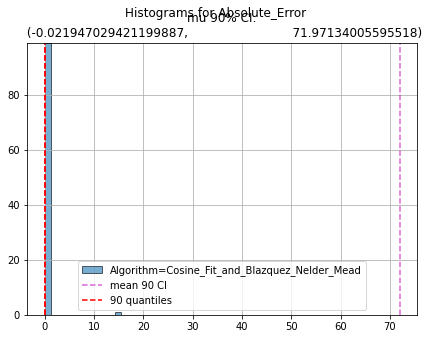

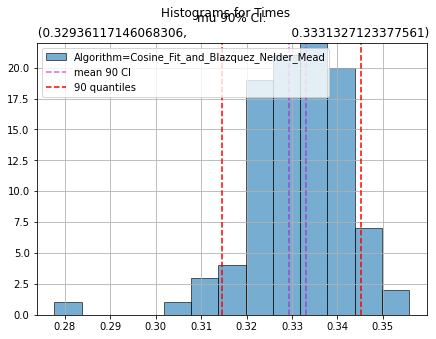

In [173]:
%%skip $use_experimental
table_per_alg={}
table_per_image={}
exp_names=['Simultaed_Normalize_to_Max_Noisy_Data'] # , 'Normalize_to_average', 'Sigmoid de parametros tal y cual']
# List the Algorithms to test
for exp_name in exp_names:
    algorithm_lambda_list = [
        lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(refs, pbs, image_pair_names,
                                                           polar_histogram_preprocess_fct, squared_cosine_NM_alg_kw_args),
        '''
        lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(refs, pbs, image_pair_names,
                                                           polar_histogram_preprocess_fct, squared_cosine_Pow_alg_kw_args),
        lambda refs, pbs, dir_alg : run_squared_cosine_fit_and_Carles(refs, pbs, image_pair_names,
         
        lambda refs, pbs, dir_alg : run_gradient_regression(refs, pbs, image_pair_names, 
                                                            preprocess_fct=naive_rotation_preprocess_fct ),
        
        lambda refs, pbs, dir_alg : run_histogram_intra_class_var(refs, pbs, image_pair_names, 
                                preprocess_fct=polar_fourier_preprocess_fct, polar_hist_alg_kw_args=polar_hist_alg_kw_args),
        
        lambda refs, pbs, dir_alg : run_angle_predictor_model(model_simple_encoder, refs, pbs, image_pair_names),
        lambda refs, pbs, dir_alg : run_angle_predictor_model(model_encoder_fc, refs, pbs, image_pair_names),
        
        lambda refs, pbs, dir_alg : run_knn_on_embedding_space(refs, pbs, image_pair_names,   
                       trained_knn_alg_triplet),
        
        lambda refs, pbs, dir_alg : run_knn_on_embedding_space(refs, pbs, image_pair_names,   
                       trained_knn_alg),
        
        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(
                    refs, pbs, image_pair_names, preprocess_fct=naive_rotation_preprocess_fct,
                    search_algorithm="fibonacci", search_alg_kw_args=naive_rotation_fibo_kw_args,
                    rotation_alg_kw_args=naive_rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_naive_affine_rotation_algorithm(
                    refs, pbs, image_pair_names, preprocess_fct=naive_rotation_preprocess_fct,
                    search_algorithm="quadratic", search_alg_kw_args=naive_rotation_quad_kw_args,
                    rotation_alg_kw_args=naive_rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),
        
        
        lambda refs, pbs, dir_alg : run_polar_fourier_phase_correlation(refs, pbs, image_pair_names, 
                    preprocess_fct=polar_fourier_preprocess_fct, polar_fourier_alg_kw_args=polar_fourier_alg_kw_args),
        
        
        #lambda refs, pbs, dir_alg : run_simulation_algorithm(references=refs, problems=pbs,
        #            image_pair_names=image_pair_names, preprocess_fct=simulation_preprocess_fct,
        #            search_algorithm="fibonacci", search_alg_kw_args=simulation_fibo_kw_args,
        #            simulation_alg_kw_args=simulation_alg_kw_args, out_plot_path=dir_alg, simulation_algorithm=None,
        #            mirror_alg_kw_args=mirror_alg_sim_kw_args),

        #lambda refs, pbs, dir_alg : run_simulation_algorithm(references=refs, problems=pbs,
        #            image_pair_names=image_pair_names, preprocess_fct=simulation_preprocess_fct,
        #            search_algorithm="quadratic", search_alg_kw_args=simulation_quad_kw_args,
        #            simulation_alg_kw_args=simulation_alg_kw_args, out_plot_path=dir_alg, simulation_algorithm=None,
        #                                mirror_alg_kw_args=mirror_alg_sim_kw_args),
        
        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=mirror_preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=mirror_fibo_kw_args,
                        mirror_alg_kw_args=mirror_alg_kw_args, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=rotation_preprocess_fct,
                        search_algorithm="fibonacci", search_alg_kw_args=rotation_fibo_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),

        lambda refs, pbs, dir_alg : run_mirror_flip_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=mirror_preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=mirror_quad_kw_args,
                        mirror_alg_kw_args=mirror_alg_kw_args, out_plot_path=dir_alg, mirror_algorithm=None),

        lambda refs, pbs, dir_alg : run_rotation_algorithm(references=refs, problems=pbs, 
                        image_pair_names=image_pair_names, preprocess_fct=rotation_preprocess_fct,
                        search_algorithm="quadratic", search_alg_kw_args=rotation_quad_kw_args,
                        rotation_alg_kw_args=rotation_alg_kw_args, out_plot_path=dir_alg, rotation_algorithm=None),

        '''
    ]

    # Label for the name of each algorithm to try in the pipeline
    algorithm_name_list = [
        "Cosine_Fit_and_Blazquez_Nelder_Mead",
        #"Cosine_Fit_and_Blazquez_Powell",
        #"Cosine_Fit_and_Blazquez_Bayesian",
        #"Gradient_Regression",
        #"Histogram_IntraClass_Variance",
        #"CNN_Simple_Encoder", # Trained a saco
        #"CNN_Encoder_and_several_fc", # trained partiendo de CNN del embedder
        #"KNN_Triplet_Encoder_Embedding_Space",
        #"KNN_PCA_Embedding_Space",
        #"Naive_Rotation_Fibonacci_Ratio_Search",
        #"Naive_Rotation_Quadratic_Fit_Search",
        #"Polar_Fourier_Phase_Correlation",
        #"Simulation_Coord_Desc_Fibonacci_Ratio_Search",
        #"Simulation_Coord_Desc_Quadratic_Ratio_Search",
        #"Mirror_Flip_Fibonacci_Ratio_Search",
        #"Rotation_Fibonacci_Ratio_Search",
        #"Mirror_Flip_Quadratic_Fit_Search",
        #"Rotation_Quadratic_Fit_Search"    
    ]


    # Run the pipeline!
    table_per_image[exp_name], table_per_alg[exp_name] = run_benchmark_output_result_histograms_and_result_table(
        algorithm_lambda_list=algorithm_lambda_list, algorithm_name_list=algorithm_name_list,
        references=X_references, problems=X_problems, image_pair_names=image_pair_names,
        generate_algorithm_plots=True,
        generate_histograms=True, boots_samples=boots_samples, confidence=confidence,
        output_units=output_units, ground_truths=ground_truths, GT_units=GT_units,
        GT_nature = GT_nature,
        experiment_name = exp_name, 
        output_path=output_path)

# Generate Excel files!
# Excel for algorithms
writer = StyleFrame.ExcelWriter(f'{output_path}/EXCEL_Results_per_Algorithm.xlsx')
for exp_name in exp_names:
    StyleFrame(pd.DataFrame({'Absolute Error':['Absolute_Error']})).to_excel(writer, sheet_name=exp_name, startcol=1)
    StyleFrame(pd.DataFrame({'Times':['Times']})).to_excel(writer, sheet_name=exp_name, startcol=5)
    sf = StyleFrame(pd.DataFrame(table_per_alg[exp_name].index.get_level_values(0)))
    sf.set_column_width(columns=[1], width=55.0)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1)
    sf = StyleFrame(table_per_alg[exp_name]['Absolute_Error'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.5)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1, startcol=1, float_format="%.5f")
    sf = StyleFrame(table_per_alg[exp_name]['Times'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.0)
    sf.to_excel(writer, sheet_name=exp_name,  startrow=1, startcol=5, float_format="%.5f")
writer.save()

# Excel for images
writer = StyleFrame.ExcelWriter(f"{output_path}/EXCEL_Results_per_Image.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
for exp_name in exp_names:
    StyleFrame(table_per_image[exp_name]).set_row_height(1,50).to_excel(writer, best_fit=list(table_per_image[exp_name].columns), sheet_name=exp_name, index=False,  float_format="%.8f")
writer.save()



In [174]:
%%skip $use_experimental
table_per_alg[exp_names[0]] # menos precision en fibo

Absolute_Error                         \
                                              Mean Standard_Dev CI_90_low   
Cosine_Fit_and_Blazquez_Nelder_Mead       0.158992     1.543114 -0.021947   

                                                  Times               \
                                     CI_90_up      Mean Standard_Dev   
Cosine_Fit_and_Blazquez_Nelder_Mead  71.97134  0.331397     0.011041   

                                                         
                                    CI_90_low  CI_90_up  
Cosine_Fit_and_Blazquez_Nelder_Mead  0.329361  0.333133

In [177]:
%%skip $use_experimental
table_per_image[exp_names[0]][50:]

,ID,Image_Pair_Name,Algorithm,Predicted_Delta_PhiCRs,Pred_Delta_Polarizt,Times,Ground_Truth_pol,Absolute_Error
50,50,REF_27202_PB_78735,Cosine_Fit_and_Blazquez_Nelder_Mead,-41.446391,-20.723196,0.340143,-20.724787,0.001591
51,51,REF_81377_PB_82688,Cosine_Fit_and_Blazquez_Nelder_Mead,-48.490293,-24.245146,0.331278,-24.245111,0.000036
52,52,REF_19143_PB_93924,Cosine_Fit_and_Blazquez_Nelder_Mead,-44.378190,-22.189095,0.325248,-22.193361,0.004266
53,53,REF_33500_PB_8620,Cosine_Fit_and_Blazquez_Nelder_Mead,-9.360893,-4.680446,0.332875,-4.686428,0.005982
54,54,REF_12747_PB_87737,Cosine_Fit_and_Blazquez_Nelder_Mead,-163.863010,-81.931505,0.339844,-81.929050,0.002455
55,55,REF_51690_PB_51387,Cosine_Fit_and_Blazquez_Nelder_Mead,46.145177,23.072588,0.336010,23.067222,0.005366
56,56,REF_51502_PB_17572,Cosine_Fit_and_Blazquez_Nelder_Mead,10.008810,5.004405,0.332621,5.002116,0.002289
57,57,REF_9390_PB_90325,Cosine_Fit_and_Blazquez_Nelder_Mead,59.706871,29.853436,0.343755,29.856195,0.002759
58,58,REF_83442_PB_8336,Cosine_Fit_and_Blazquez_Nelder_Mead,-133.688382,-66.844191,0.343984,-66.838548,0.005643
59,59,REF_44890_PB_96275,Cosine_Fit_and_Blazquez_Nelder_Mead,-119.195070,-59.597535,0.340702,-59.593450,0.004085


In [43]:
hist = imR_polar.sum(axis=1)
hist = hist/hist.sum()

weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]
bin_centers = list(range(0, len(hist)))
mean1 = np.cumsum(hist * bin_centers) / weight1
mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
otsu = bin_centers[np.nanargmax(variance)]
var = np.nanmax(variance)
print(var)
plt.plot(hist, '-r')
plt.axvline(otsu)
plt.show()

NameError: name 'imR_polar' is not defined

In [ ]:
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar
import cv2
import numpy as np
import matplotlib.pyplot as plt

theta_num=360*10**1
rad_num=50
desired_theta_ac = 3600

def plot(im):
    plt.imshow(im, cmap='gray')
    plt.show()
    
imR=cv2.imread("../EXPERIMENTAL/TEST_IMAGES/IM_5_phiCR_-2.6049387454986572.png", cv2.IMREAD_GRAYSCALE)
imP=cv2.imread("../EXPERIMENTAL/TEST_IMAGES/IM_6_phiCR_-1.7562638521194458.png", cv2.IMREAD_GRAYSCALE)
radius = 2*imR.shape[0]//3
print(imR.shape)
#plot(imP)
imR_polar = warp_polar(imR, center=compute_intensity_gravity_center(imR), 
                       output_shape=(theta_num, rad_num), radius=radius, scaling='linear', order=3) # number of rows will be 2pi
imP_polar = warp_polar(imP, center=compute_intensity_gravity_center(imP), 
                       output_shape=(theta_num,rad_num), radius=radius, scaling='linear', order=3)

'''
         - 0: Nearest-neighbor
         - 1: Bi-linear (default)
         - 2: Bi-quadratic
         - 3: Bi-cubic
         - 4: Bi-quartic
         - 5: Bi-quintic
'''
print(imR_polar.shape)
#plot(imR_polar)
#plot(imP_polar)
plot(imR)
plt.plot(imR_polar.sum(axis=1), '-', markersize=1)
plt.show()
'''
# A. Directly register the log-polar images using Fourier phase correlation -> assumes no translational difference present!
print("Register directly ########")
# space Defines how the algorithm interprets input data. “real” means data will be FFT’d to compute the correlation, while “fourier” data will bypass FFT of input data. 
# images will be registered to within 1 / upsample_factor of a pixel.
shifts, error, phasediff = phase_cross_correlation(imR_polar, imP_polar, normalization='phase',
                                             upsample_factor=desired_theta_ac/theta_num,  space='real')
print(shifts, error, phasediff)

gt = (-1.7562638521194458+2.6049387454986572)
found = shifts[0]/theta_num*2*np.pi
print("Found:",found/np.pi*180, "Ground truth", gt/np.pi*180, ' Estimated error', error)


# B. Register the Fourier maps of the polar plots! They should be translation invariant!
from scipy.fft import fft2, fftshift
# First, band-pass filter both images
#image = difference_of_gaussians(image, 5, 20)
#rts_image = difference_of_gaussians(rts_image, 5, 20)
print("Refister Fourier magnitudes in polar coords #########")

# work with shifted FFT magnitudes
imP_F = np.abs(fftshift(fft2(imP)))
imR_F = np.abs(fftshift(fft2(imR)))

#polar_imP_F = imP_F
#polar_imR_F = imR_F
# Create log-polar transformed FFT mag images and register
radius = imP_F.shape[0]  # only take lower frequencies
polar_imP_F = warp_polar(imP_F, radius=radius, output_shape=(theta_num, rad_num),
                             scaling='linear', order=1)
polar_imR_F = warp_polar(imR_F, radius=radius, output_shape=(theta_num, rad_num),
                           scaling='linear', order=1)

shifts, error, phasediff = phase_cross_correlation(np.log(1+polar_imR_F), np.log(1+polar_imP_F), normalization='phase',
                            upsample_factor=desired_theta_ac/theta_num,  space='real') # relamente no es real pero bueno xD
found = shifts[0]/theta_num*2*np.pi
print(shifts, error, phasediff)
print("Found:",found/np.pi*180, "Ground truth", gt/np.pi*180)

# Use translation parameters to calculate rotation and scaling parameters

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Problem Image log FFT\n(magnitude; zoomed)")
ax[0].imshow(np.log(imP_F+1),
             cmap='magma')
ax[1].set_title("Reference Image log FFT\n(magnitude; zoomed)")
ax[1].imshow(np.log(1+imR_F),
             cmap='magma')
ax[2].set_title("Log-Polar-Transformed\nProblem FFT")
ax[2].imshow(polar_imP_F, cmap='magma')
ax[3].set_title("Log-Polar-Transformed\nReference FFT")
ax[3].imshow(polar_imR_F, cmap='magma')
plt.show()
'''
